We wanted to examine some further areas for post-error slowing and RTFS. Previous analyses suggested there may be some overlap, and I wanted to futher explore possible locations.

Wanted to explore:
    
 - rumination
 - dlPFC
 - vmPFC
 - resting-state
 
Considered several atlases for dlPFC and vmPFC

vmPFC is straightforward; in the Harvard-Oxford Cortical Structural Atlas, it's the frontal medial cortex.

dlPFC is harder:

 - functional meta-analyses from neurosynth. Counterintuitive but the maps are surprisingly good
 - None of the ones built into FSLeyes delineate dlPFC. As it's a functional area, it isn't contained on maps. 'Middle frontal gyrus' is probably a reasonable proxy though.
 - Freesurfer atlases from https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation. They're very good, and we already have the per-subject parcellations in the subject directories. Labels are in text files in `/gpfs/projects/sanlab/shared/DEV/bids_data/derivatives/freesurfer/sub-DEV*/label/*` and relevant files  in eg.g.`/gpfs/projects/sanlab/shared/DEV/bids_data/derivatives/fmriprep/sub-DEV081/ses-wave1/func/sub-DEV081_ses-wave1_task-ROC_acq-4_bold_space-T1w_label-aparcaseg_roi.nii.gz`.

So we're going with dlPFC, middle frontal gyrus, and resting-state. Can't find any keyword for "rumination".

In [3]:
import sys
import os
import pandas as pd
from os import path

import pickle
from IPython.core.display import display, HTML, Markdown

sys.path.append(os.path.abspath("../../ml/"))

from apply_loocv_and_save import *
from dev_wtp_io_utils import *
import gc
import nibabel as nib

nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20210601T183243.csv"
test_train_df = pd.read_csv(train_test_markers_filepath)

all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")


dataset_name = 'posterror_conditions'

from nilearn.decoding import DecoderRegressor, Decoder

script_path = '/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml'
# HRF 2s

#get a PFC mask
#pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)
#get the masks we want




python initialized for apply_loocv_and_save
4


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [4]:
background_img = nlt.Brain_Data('/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain.nii').to_nifti()

neurosynth_emo_reg_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/emotion regulation_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
neurosynth_error_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/error_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
accmask = nlt.Brain_Data(ml_data_folderpath + '/masks/harvardoxford-cortical_prob_Cingulate Gyrus, anterior division.nii.gz').threshold(binarize=True,upper=25).to_nifti()



/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [16]:
from analyze_results import plot_stat_maps, get_bd, visualize_corr, get_ind_div_for_pes_combined, create_histogram
from analyze_results import outlier_detection_carling, outlier_detection_median_sd

def remove_selected_outliers(ind_div_combined,show_plot=False):
    for cname in ['pes_mean_limited','PostErrorSlowW1','IPAQ_MET_kCal','PC_trials_PostError_similarity','PE_trials_PostError_similarity',
                 'PC_trials_PostCorrect_similarity','PE_trials_PostCorrect_similarity']:
        display(HTML(cname))
        display(HTML('carling'))
        carling = outlier_detection_carling(ind_div_combined[cname],show_plot=show_plot)
        display(HTML('3sd'))
        sd_3 = outlier_detection_median_sd(ind_div_combined[cname],show_plot=show_plot)
        
        ind_div_combined[cname] = carling
    
    return(ind_div_combined)


In [17]:




def run_full_pes_analysis_no_male_specific(mask_label,mask_file,similarity_method):
    dataset_mask_label = mask_label
    relevant_mask = mask_file
    results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_" + dataset_mask_label +".pkl"
    brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'

    plotting.plot_img(
        relevant_mask,
        threshold='auto',
        cmap='autumn',
        bg_img=background_img)


    print(results_filepath)
    results=pickle.load(open(results_filepath,'rb'))

    print(np.mean(results[0]))

    PostCorrect_ns=results[3]['CorrectGoFollowingCorrectStop']
    #display(Markdown("### CorrectGoFollowingCorrectStop"))
    plotting.plot_img(PostCorrect_ns,threshold='auto',bg_img=background_img)

    PostError_ns=results[3]['CorrectGoFollowingFailedStop']
    #display(Markdown("### CorrectGoFollowingFailedStop"))
    plotting.plot_img(PostError_ns,threshold='auto',bg_img=background_img)

    print(results_filepath,flush=True)

    print("plotting signatures")

    plot_stat_maps(PostError_ns,PostCorrect_ns)

    print("loading data")

    bd=get_bd(brain_data_filepath,PostError_ns,PostCorrect_ns,relevant_mask,similarity_method=similarity_method)

    create_histogram(bd)

    ind_div_combined = get_ind_div_for_pes_combined(bd,ml_data_folderpath)

    ind_div_combined = remove_selected_outliers(ind_div_combined,show_plot=False)

    for neural_var in ['PE_trials_PostError_similarity','PC_trials_PostCorrect_similarity']:
        display(Markdown("### " + neural_var))
        for correlate in ['RTFS_f1_minus_f2','RTFS_factor_1','RTFS_factor_2','SST_SSRT','pes_mean_limited','PostErrorSlowW1','cancer_promoting_minus_preventing_FFQ',
            'cancer_promoting_FFQ','cancer_preventing_FFQ']:
            visualize_corr(neural_var,correlate,ind_div_combined)
            
    for bs_f in ['Female']:
        display(Markdown("### " + bs_f))
        for neural_var in ['PE_trials_PostError_similarity','PC_trials_PostCorrect_similarity']:
            display(Markdown("#### " + neural_var))
            for correlate in ['RTFS_f1_minus_f2','RTFS_factor_1','RTFS_factor_2','SST_SSRT','pes_mean_limited','PostErrorSlowW1','cancer_promoting_minus_preventing_FFQ',
        'cancer_promoting_FFQ','cancer_preventing_FFQ']:
                visualize_corr(neural_var,correlate,ind_div_combined.loc[ind_div_combined.birthsex_factor==bs_f,:])




# dlpfc_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_dlpfc_mask.pkl
0.7037037037037037
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_dlpfc_mask.pkl
plotting signatures


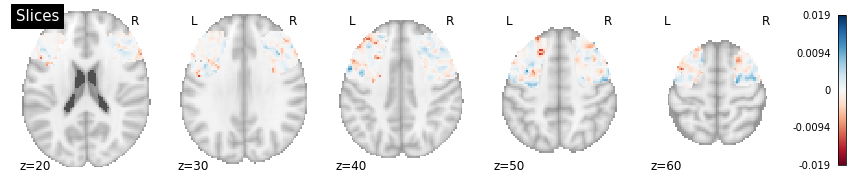

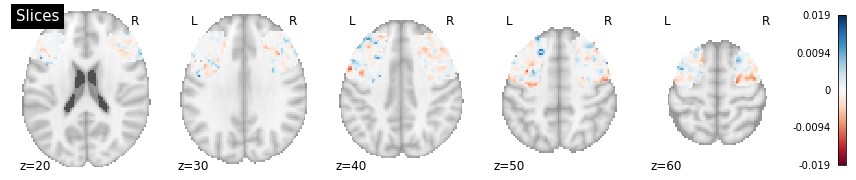

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


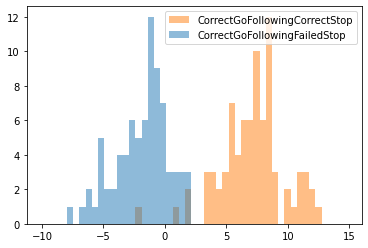

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


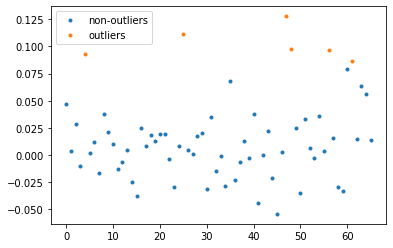

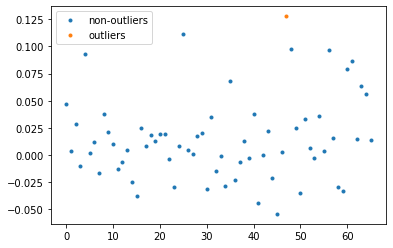

0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


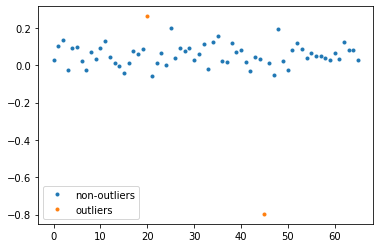

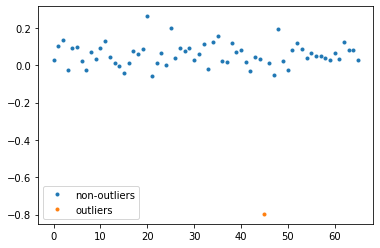

1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


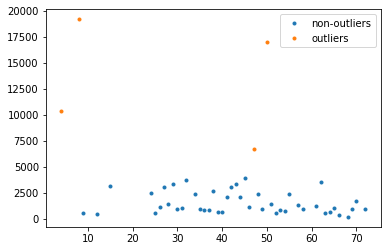

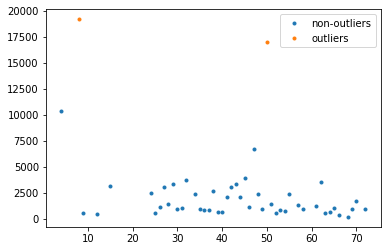

7.355166041843851 6.149683016977922 1.205483024865929 13.504849058821772


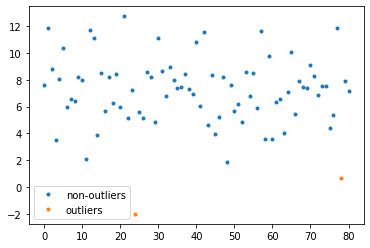

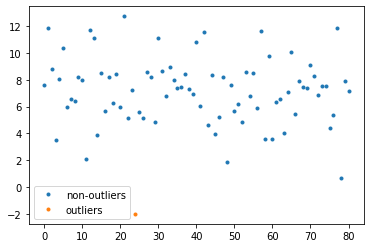

-1.4439469291768807 6.311913124573165 -7.7558600537500455 4.867966195396284


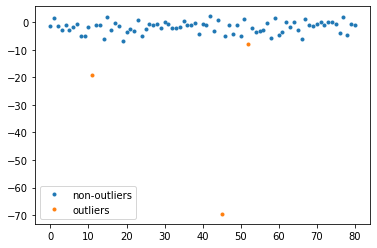

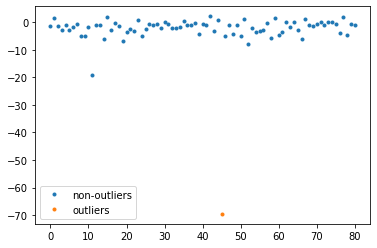

-7.355166041843851 6.149683016977922 -13.504849058821772 -1.205483024865929


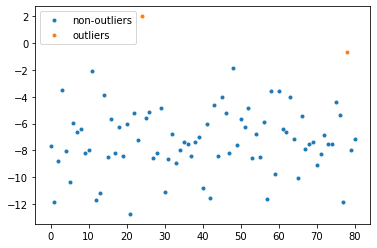

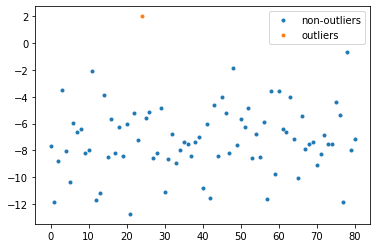

1.4439469291768807 6.311913124573165 -4.867966195396284 7.7558600537500455


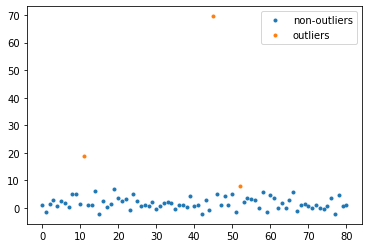

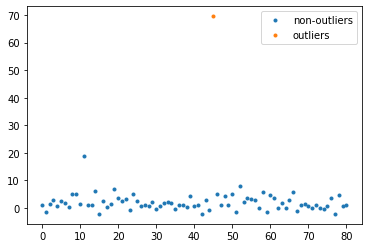

# vmpfc_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_vmpfc_mask.pkl
0.5308641975308642
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_vmpfc_mask.pkl
plotting signatures


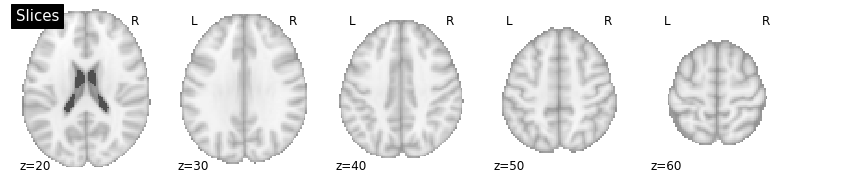

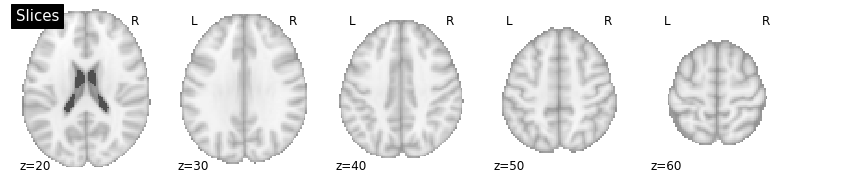

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


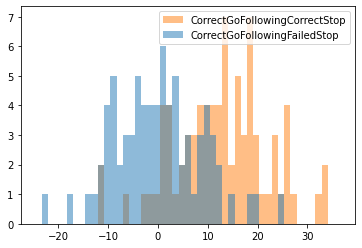

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


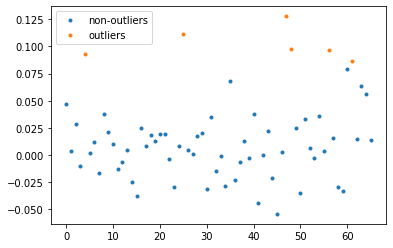

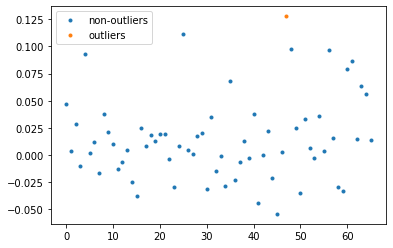

0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


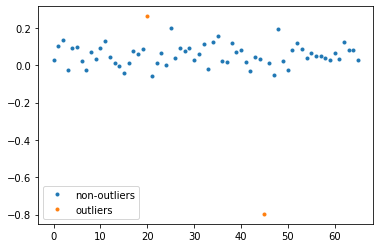

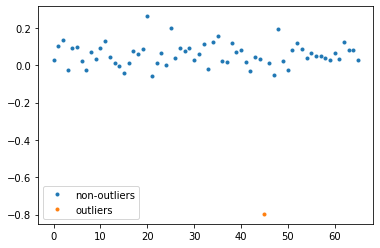

1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


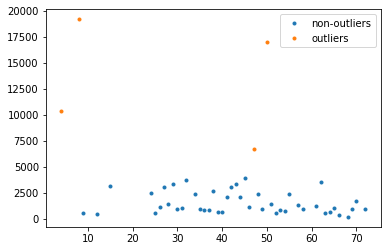

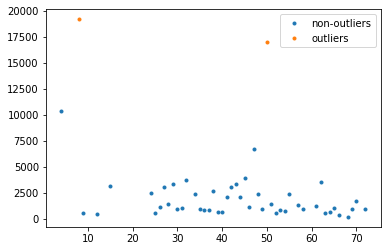

12.999535798937606 26.574634617445795 -13.57509881850819 39.5741704163834


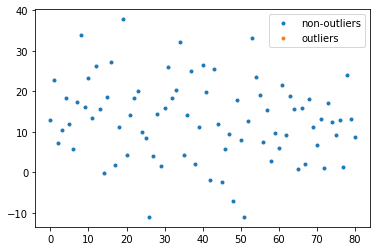

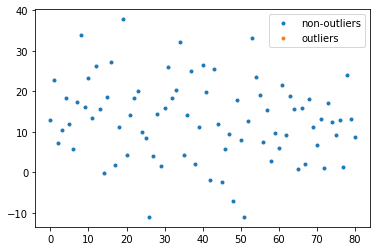

-0.07029294780143935 29.17009524234154 -29.24038819014298 29.099802294540098


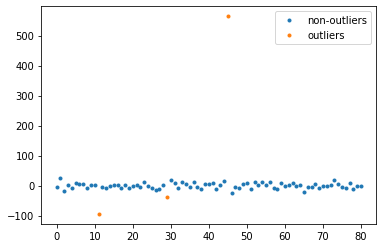

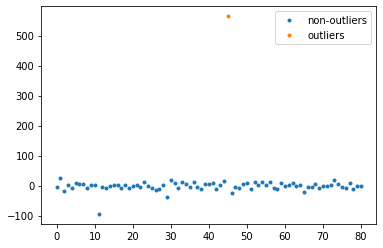

-12.999535798937606 26.574634617445795 -39.5741704163834 13.57509881850819


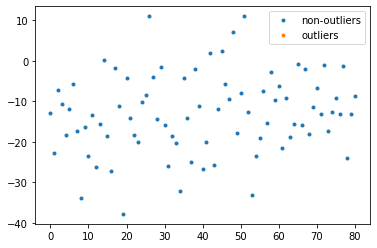

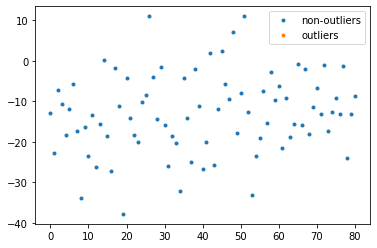

0.07029294780143935 29.17009524234154 -29.099802294540098 29.24038819014298


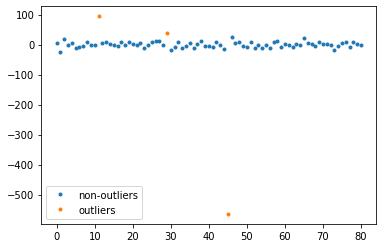

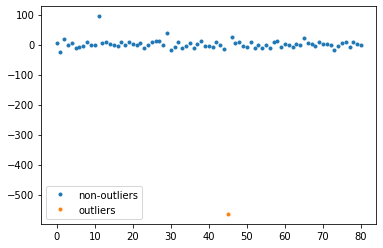

# neurosynth_resting_state_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_resting_state_mask.pkl
0.7777777777777778
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_resting_state_mask.pkl
plotting signatures


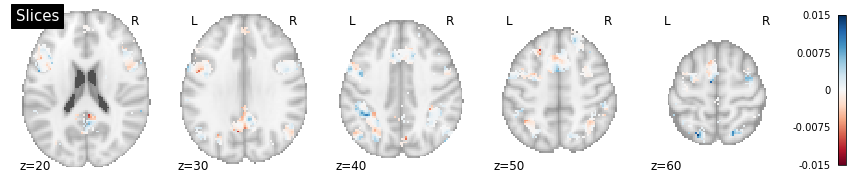

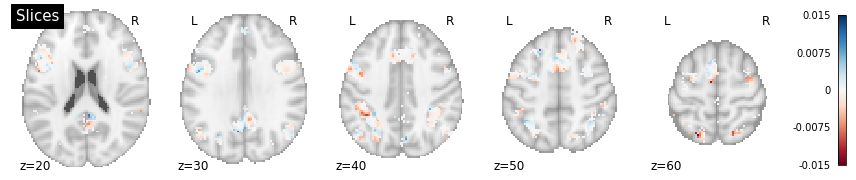

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


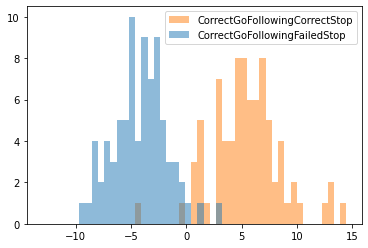

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


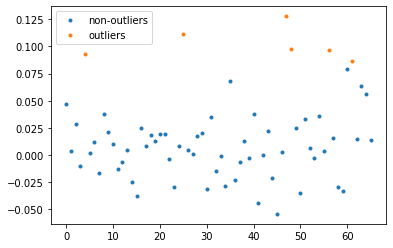

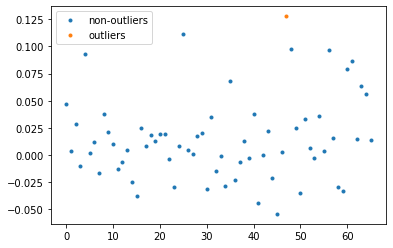

0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


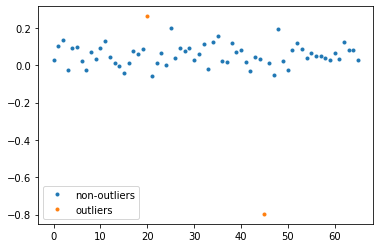

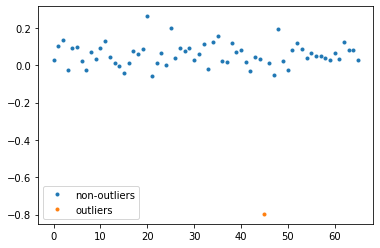

1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


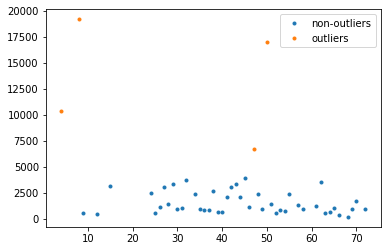

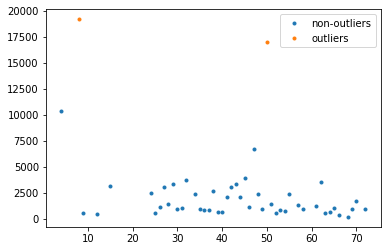

5.470541435387608 7.401635805079216 -1.9310943696916087 12.872177240466824


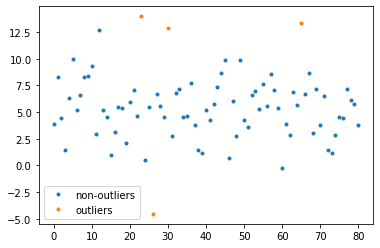

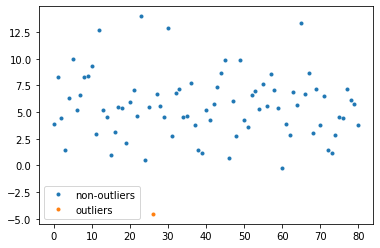

-3.886602174053728 6.576431042924943 -10.46303321697867 2.689828868871215


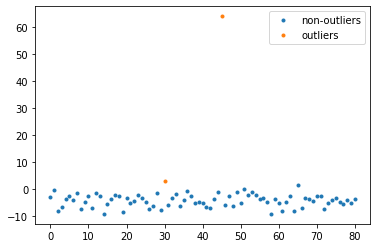

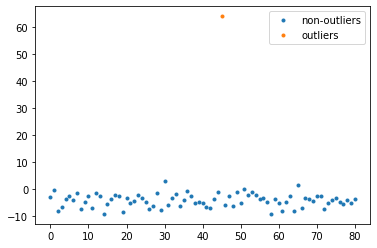

-5.470541435387608 7.401635805079216 -12.872177240466824 1.9310943696916087


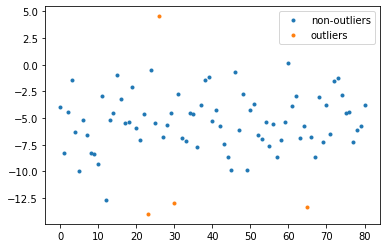

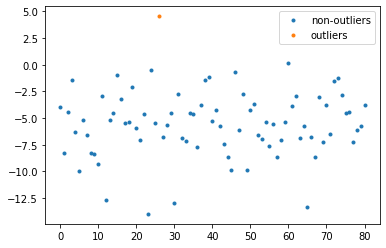

3.886602174053728 6.576431042924943 -2.689828868871215 10.46303321697867


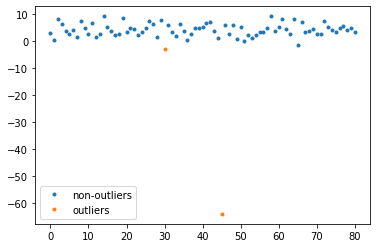

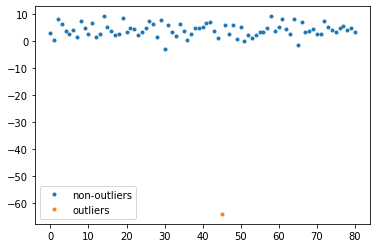

# neurosynth_vmpfc_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_vmpfc_mask.pkl
0.6851851851851852
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_vmpfc_mask.pkl
plotting signatures


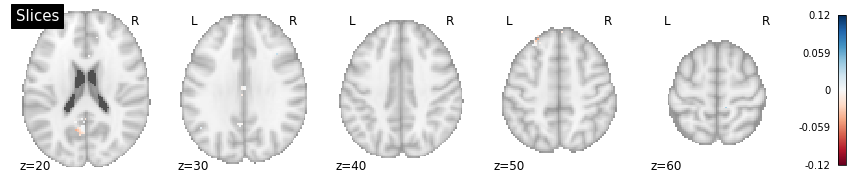

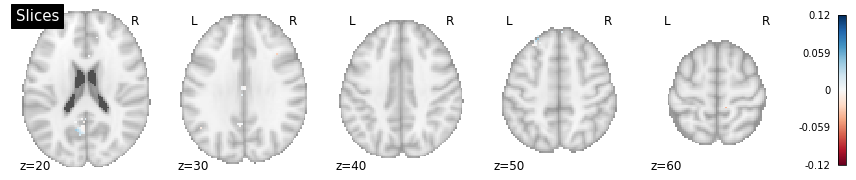

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


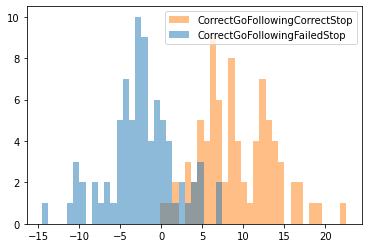

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


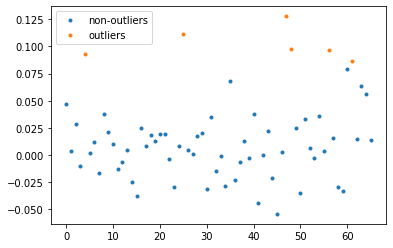

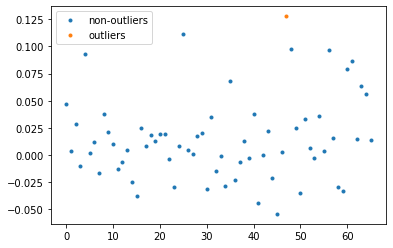

0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


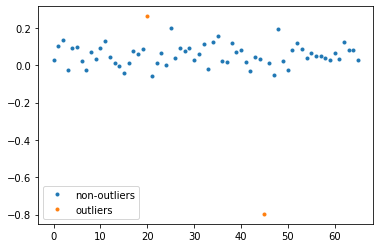

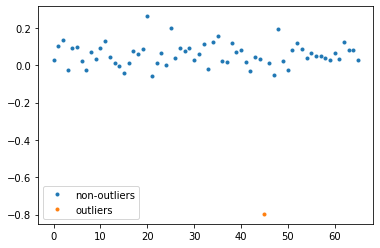

1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


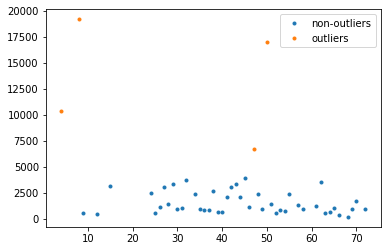

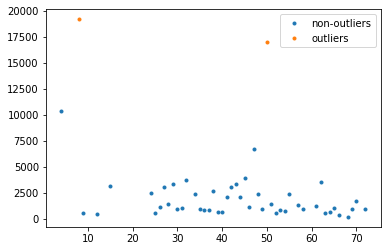

8.681308200951513 14.89693076838759 -6.2156225674360766 23.578238969339104


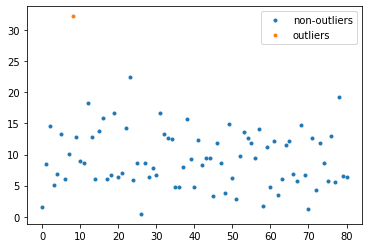

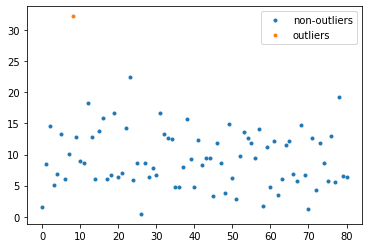

-2.626943239043872 9.609036180282645 -12.235979419326517 6.982092941238774


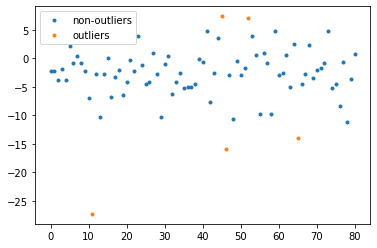

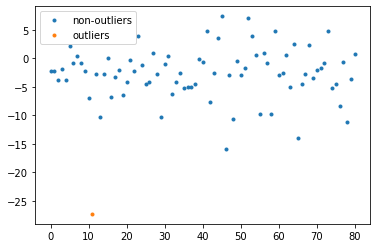

-8.681308200951513 14.89693076838759 -23.578238969339104 6.2156225674360766


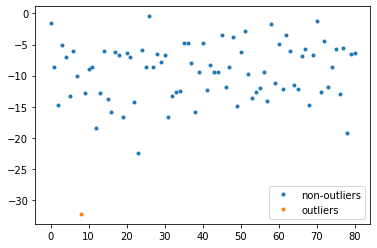

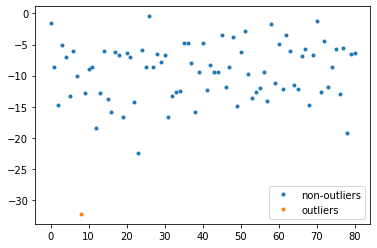

2.626943239043872 9.609036180282645 -6.982092941238774 12.235979419326517


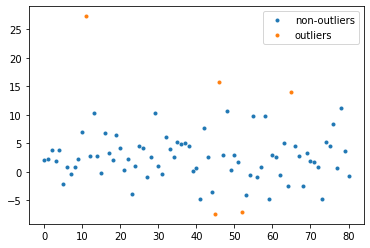

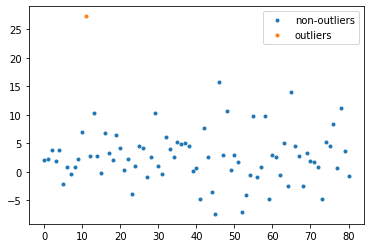

# neurosynth_dlpfc_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_dlpfc_mask.pkl
0.6172839506172839
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_dlpfc_mask.pkl
plotting signatures


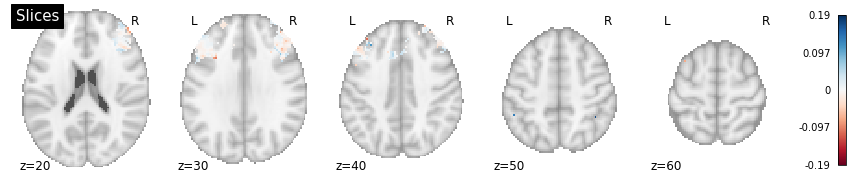

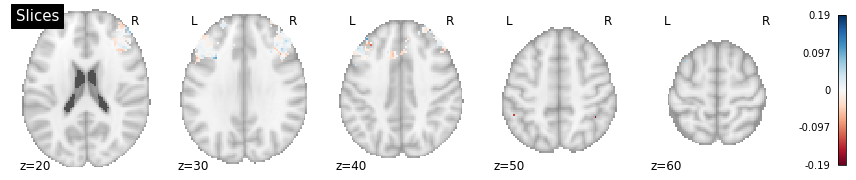

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


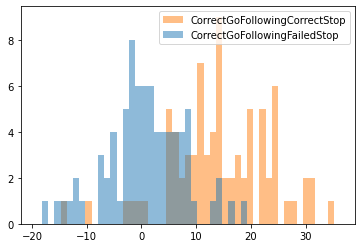

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


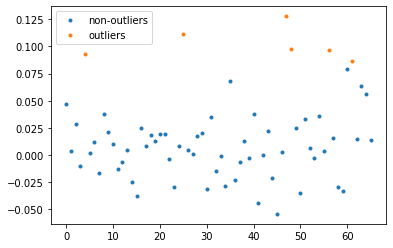

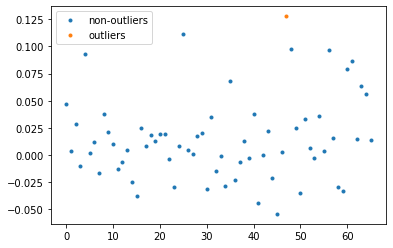

0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


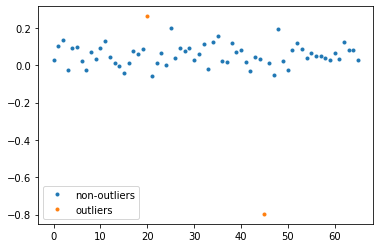

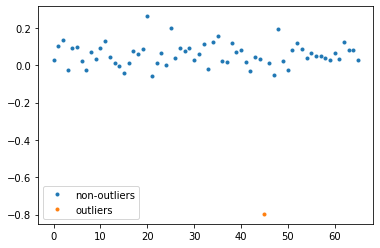

1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


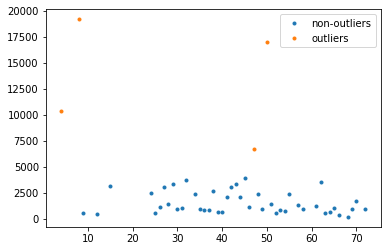

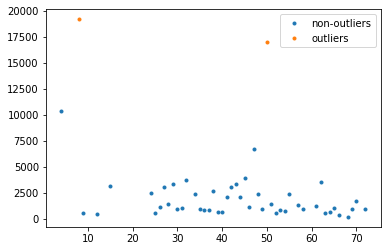

14.054854408869287 27.90605114054494 -13.851196731675651 41.96090554941423


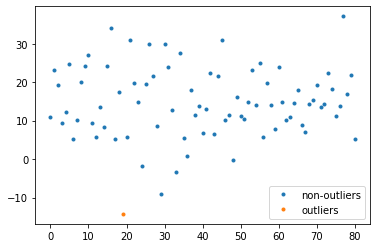

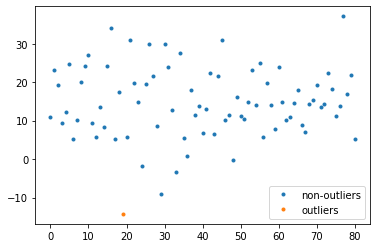

0.5413853188535305 18.48526128877542 -17.943875969921887 19.02664660762895


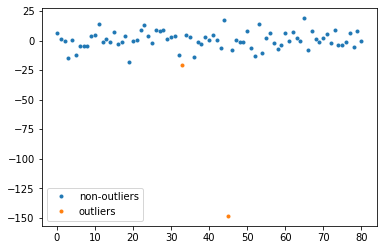

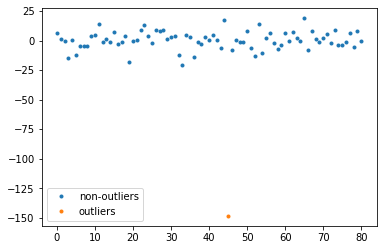

-14.054854408869287 27.90605114054494 -41.96090554941423 13.851196731675651


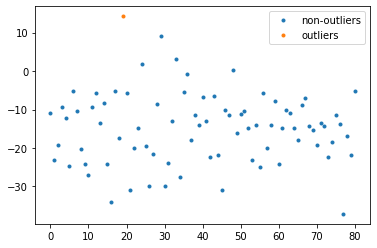

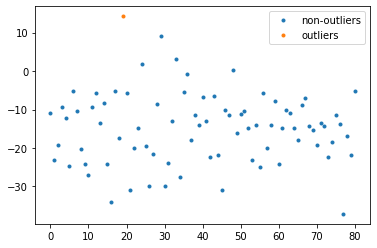

-0.5413853188535305 18.48526128877542 -19.02664660762895 17.943875969921887


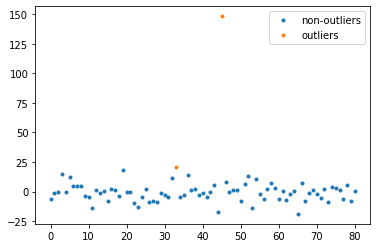

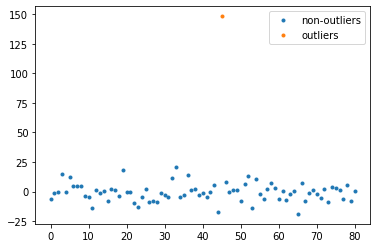

# neurosynth_negative_emotions_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_negative_emotions_mask.pkl
0.6111111111111112
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_negative_emotions_mask.pkl
plotting signatures


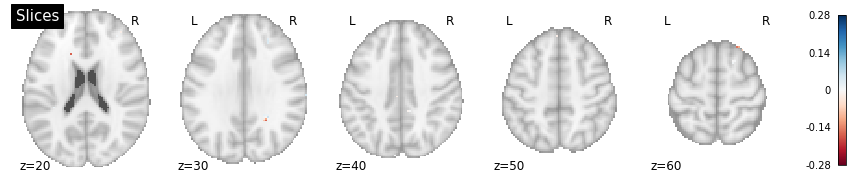

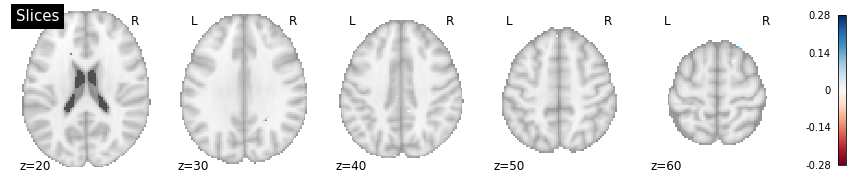

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


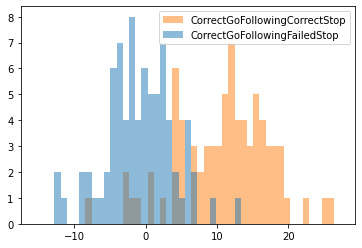

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


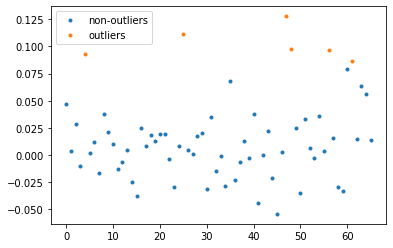

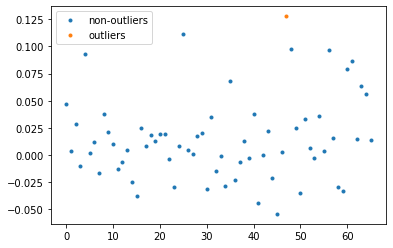

0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


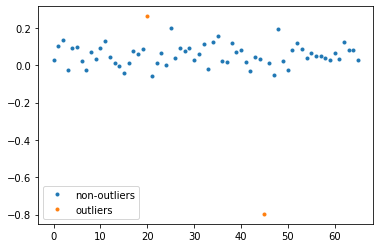

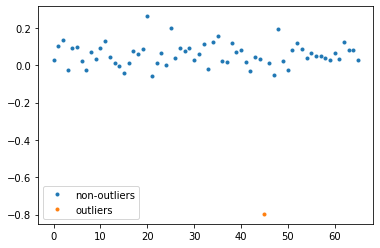

1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


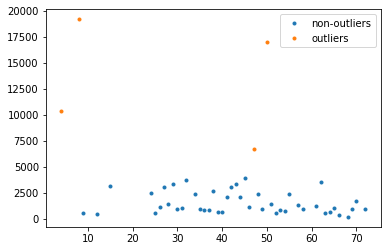

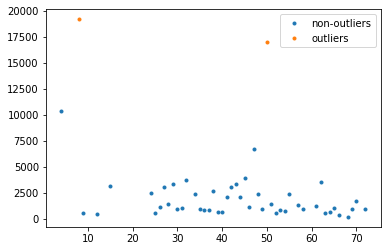

11.90211364255374 19.624286150346474 -7.722172507792735 31.526399792900214


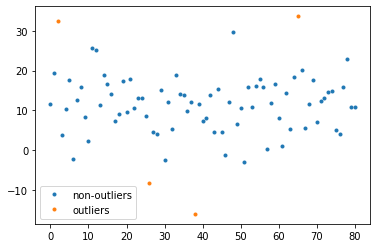

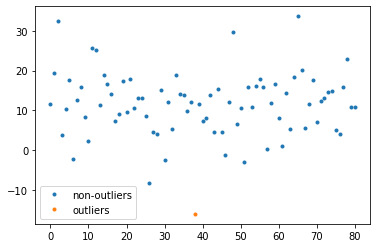

-0.881749664042365 14.18931211544186 -15.071061779484225 13.307562451399495


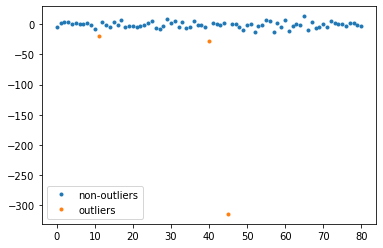

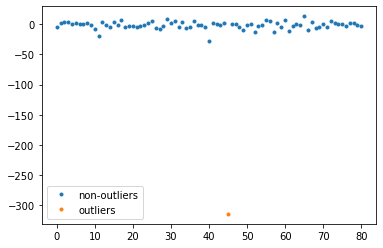

-11.90211364255374 19.624286150346474 -31.526399792900214 7.722172507792735


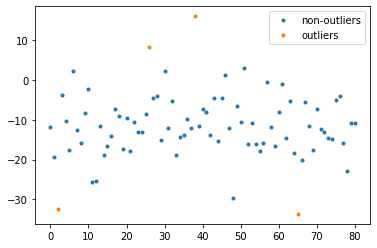

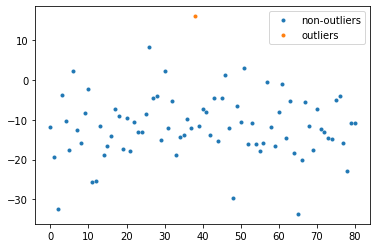

0.881749664042365 14.18931211544186 -13.307562451399495 15.071061779484225


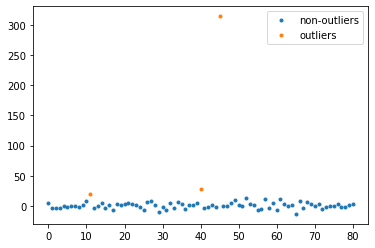

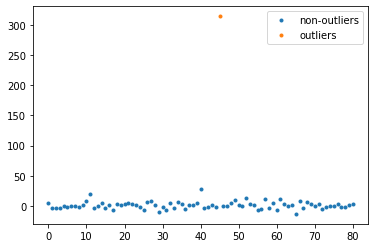

# neurosynth_negative_affect_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_negative_affect_mask.pkl
0.6481481481481481
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_negative_affect_mask.pkl
plotting signatures


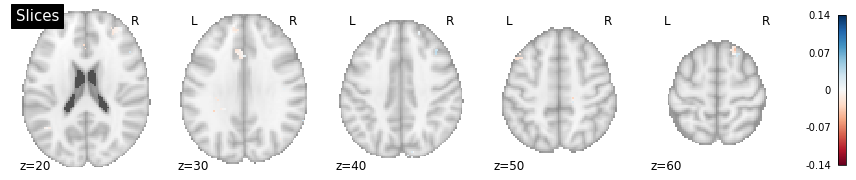

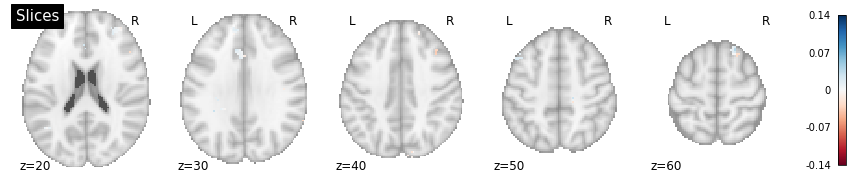

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


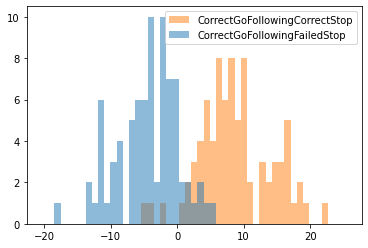

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


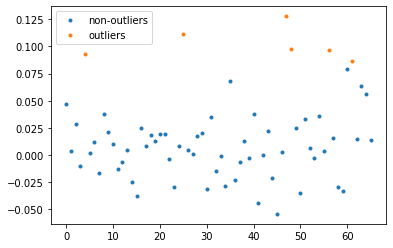

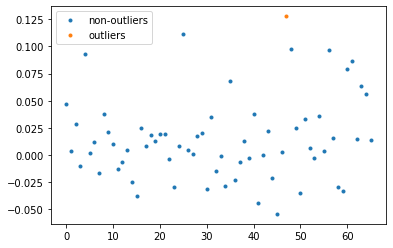

0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


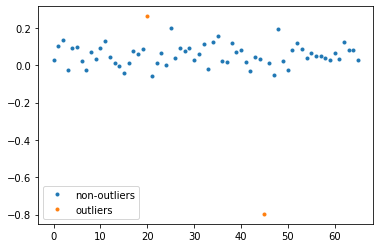

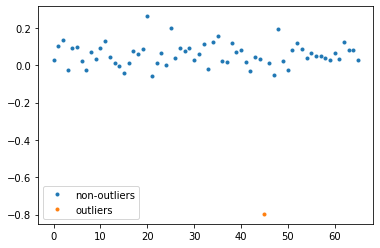

1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


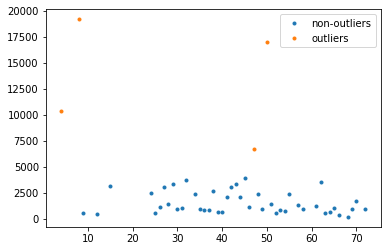

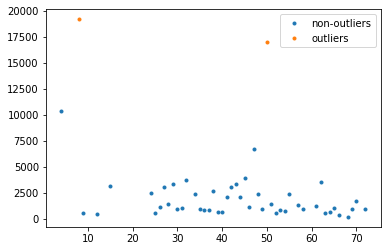

8.20947600420657 15.524837274909647 -7.315361270703077 23.734313279116215


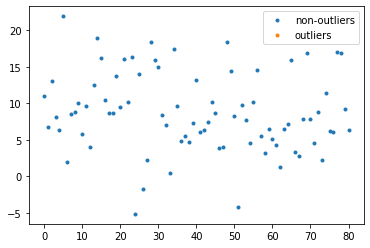

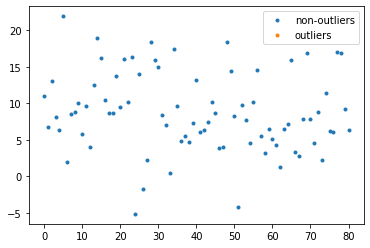

-4.10464011525852 13.214759483281782 -17.3193995985403 9.110119368023263


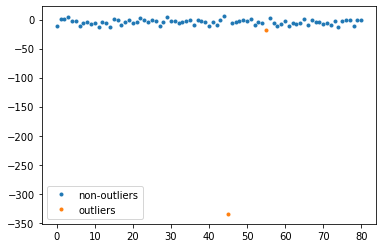

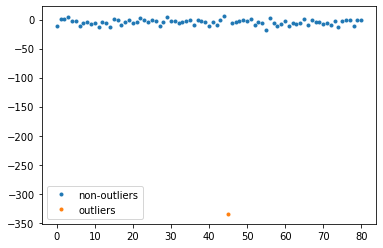

-8.20947600420657 15.524837274909647 -23.734313279116215 7.315361270703077


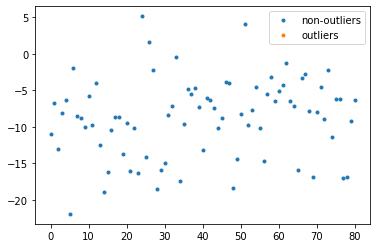

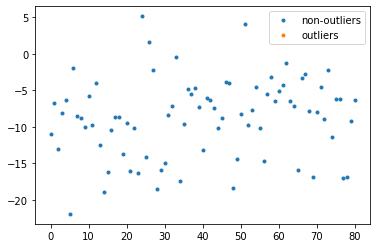

4.10464011525852 13.214759483281782 -9.110119368023263 17.3193995985403


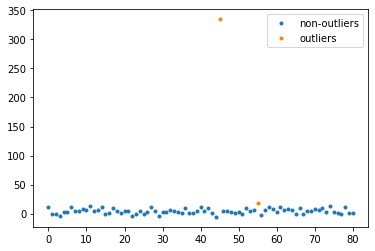

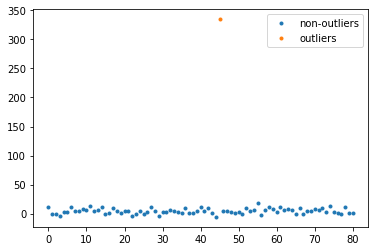

# neurosynth_self_referential_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_self_referential_mask.pkl
0.6666666666666666
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_self_referential_mask.pkl
plotting signatures


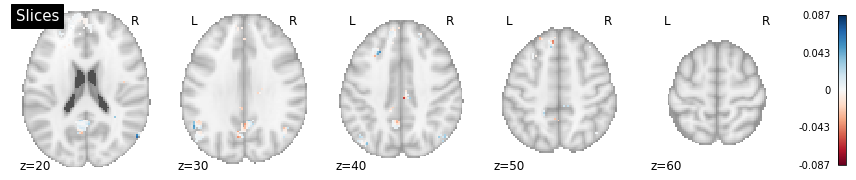

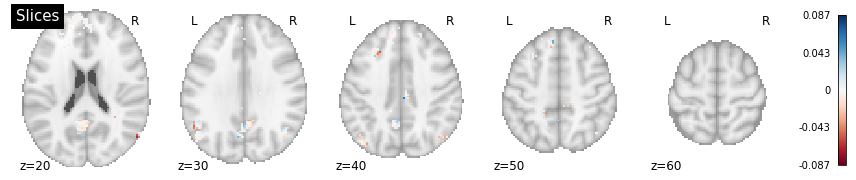

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


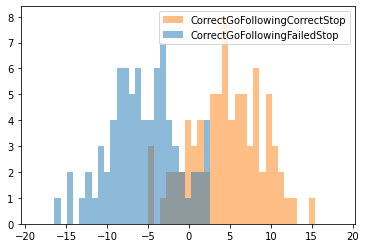

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


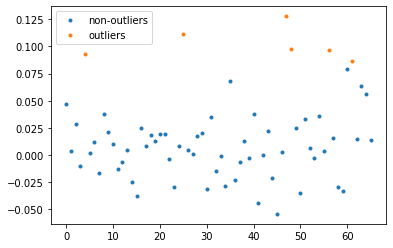

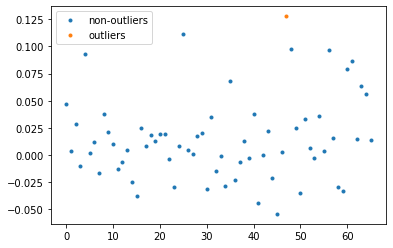

0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


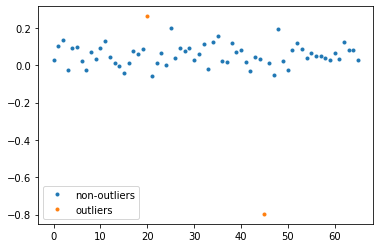

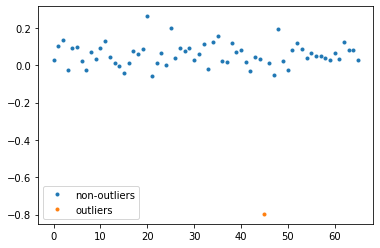

1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


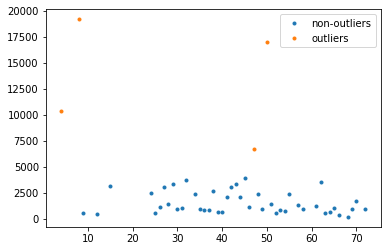

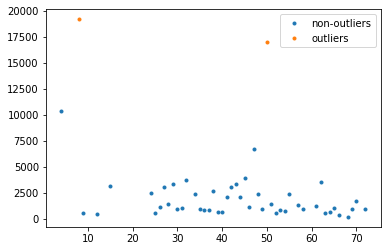

4.75617162160415 14.954550978713081 -10.198379357108932 19.710722600317233


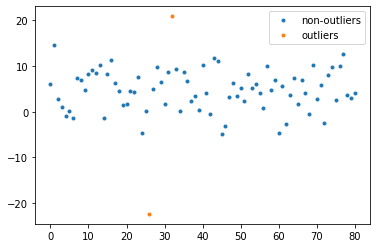

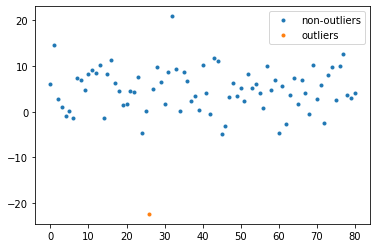

-5.512766168889337 12.482105622666186 -17.994871791555525 6.969339453776849


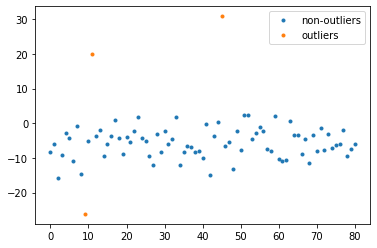

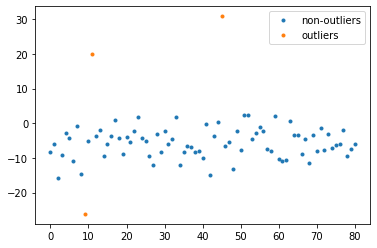

-4.75617162160415 14.954550978713081 -19.710722600317233 10.198379357108932


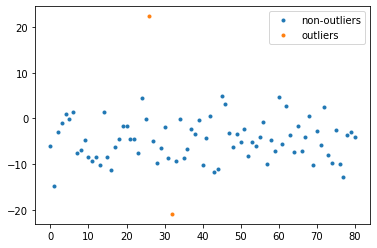

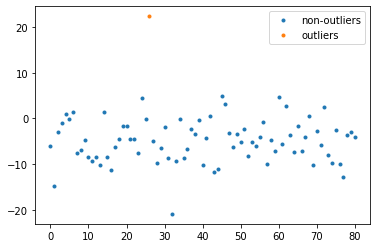

5.512766168889337 12.482105622666186 -6.969339453776849 17.994871791555525


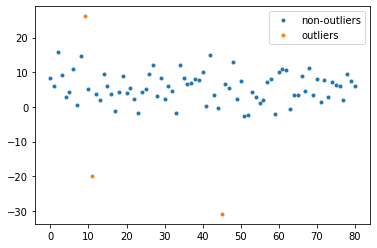

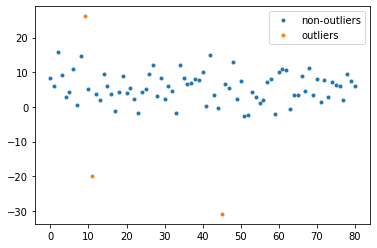

In [18]:
from analyze_results import outlier_detection_carling

def check_outlier_processing(mask_label,mask_file,similarity_method):
    dataset_mask_label = mask_label
    relevant_mask = mask_file
    results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_" + dataset_mask_label +".pkl"
    brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'

    print(results_filepath)
    results=pickle.load(open(results_filepath,'rb'))

    print(np.mean(results[0]))

    PostCorrect_ns=results[3]['CorrectGoFollowingCorrectStop']

    PostError_ns=results[3]['CorrectGoFollowingFailedStop']

    print(results_filepath,flush=True)

    print("plotting signatures")

    plot_stat_maps(PostError_ns,PostCorrect_ns)

    print("loading data")

    bd=get_bd(brain_data_filepath,PostError_ns,PostCorrect_ns,relevant_mask,similarity_method=similarity_method)

    create_histogram(bd)

    ind_div_combined = get_ind_div_for_pes_combined(bd,ml_data_folderpath)

    ind_div_combined = remove_selected_outliers(ind_div_combined,show_plot=True)

    
for k in mask_dict.keys():
    display(Markdown("# " + k))
    mask_bd = mask_dict[k]
    
    check_outlier_processing(k,mask_bd,'dot_product')

In [19]:
ml_data_folderpath

'/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml'

In [20]:
neurosynth_dlpfc_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/dlpfc_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
neurosynth_vmpfc_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/vmpfc_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
neurosynth_resting_state_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/resting state_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()

neurosynth_negative_emotions_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/negative emotions_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
neurosynth_negative_affect_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/negative affect_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
neurosynth_self_referential_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/self referential_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()


vmpfc_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/harvardoxford-cortical_prob_Frontal Medial Cortex.nii.gz').threshold(binarize=True).to_nifti()
dlpfc_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/harvardoxford-cortical_prob_Middle Frontal Gyrus.nii.gz').threshold(binarize=True).to_nifti()
#harvardoxford-cortical_prob_Frontal Medial Cortex.nii.gz


mask_dict ={
    'dlpfc_mask':dlpfc_mask,
    'vmpfc_mask':vmpfc_mask,
    'neurosynth_resting_state_mask':neurosynth_resting_state_mask,
    'neurosynth_vmpfc_mask':neurosynth_vmpfc_mask,
    'neurosynth_dlpfc_mask':neurosynth_dlpfc_mask,
    'neurosynth_negative_emotions_mask':neurosynth_negative_emotions_mask,
    'neurosynth_negative_affect_mask':neurosynth_negative_affect_mask,
    'neurosynth_self_referential_mask':neurosynth_self_referential_mask
}

# dlpfc_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_dlpfc_mask.pkl
0.7037037037037037
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_dlpfc_mask.pkl
plotting signatures


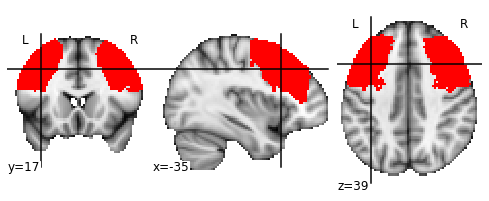

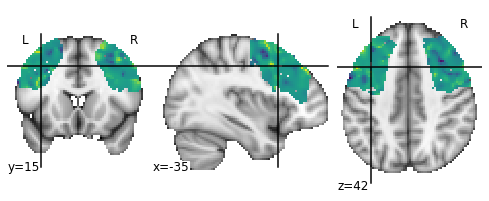

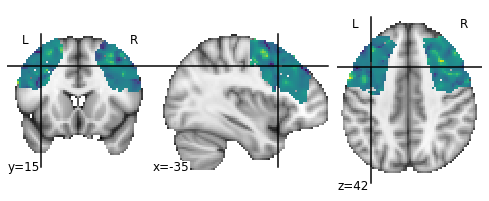

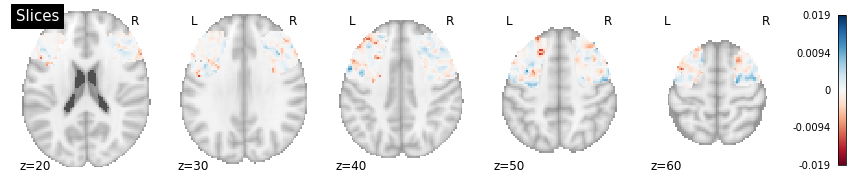

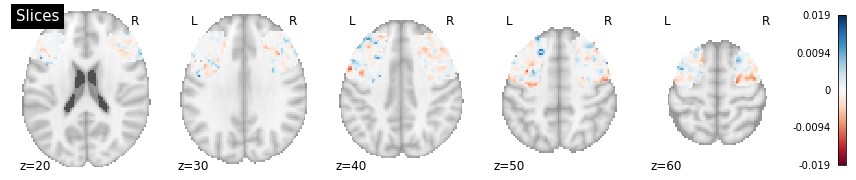

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


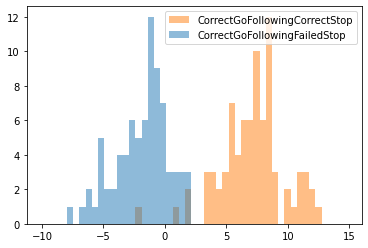

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


7.355166041843851 6.149683016977922 1.205483024865929 13.504849058821772


-1.4439469291768807 6.311913124573165 -7.7558600537500455 4.867966195396284


-7.355166041843851 6.149683016977922 -13.504849058821772 -1.205483024865929


1.4439469291768807 6.311913124573165 -4.867966195396284 7.7558600537500455


### PE_trials_PostError_similarity

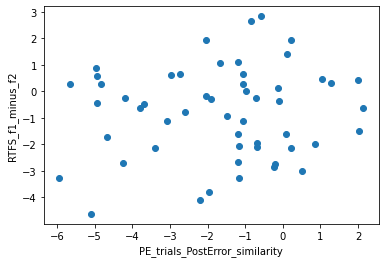

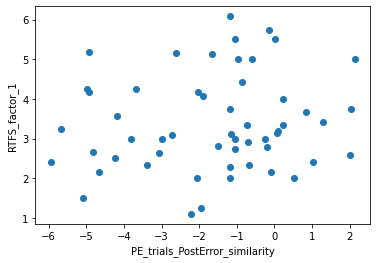

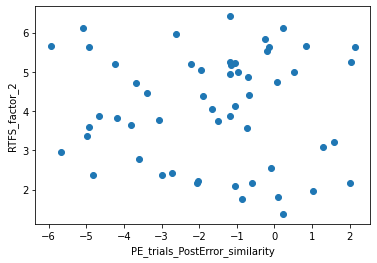

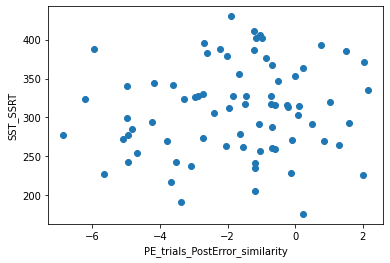

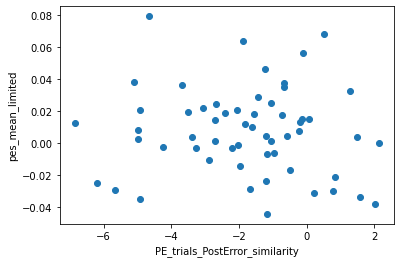

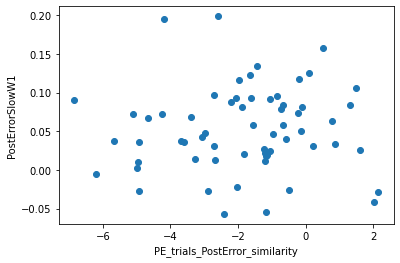

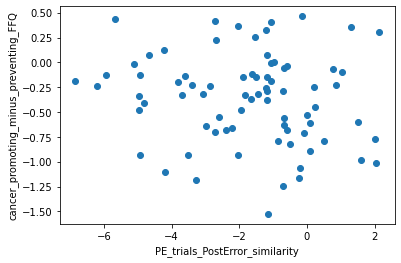

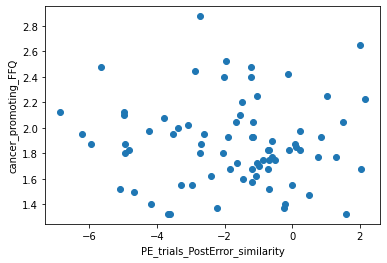

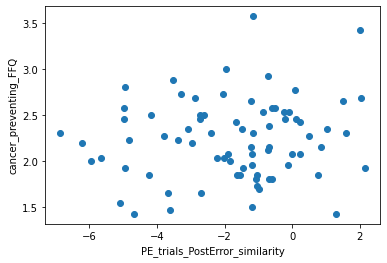

### PC_trials_PostCorrect_similarity

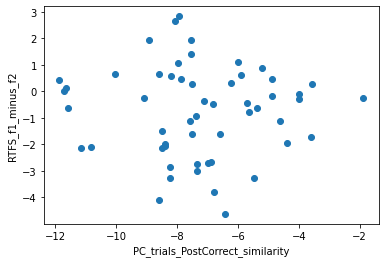

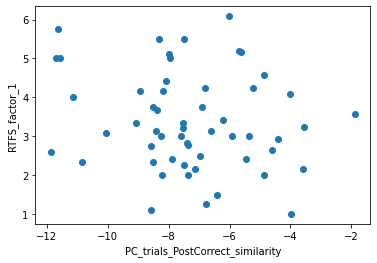

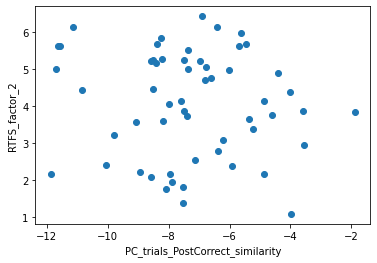

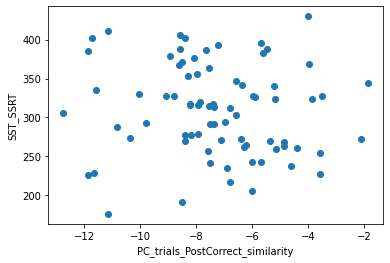

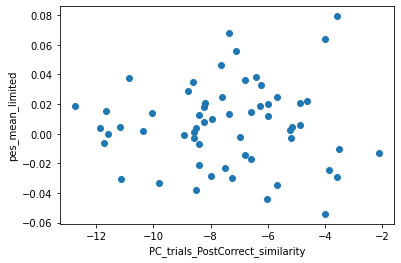

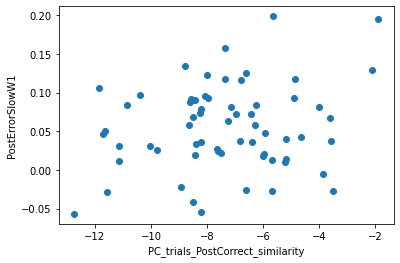

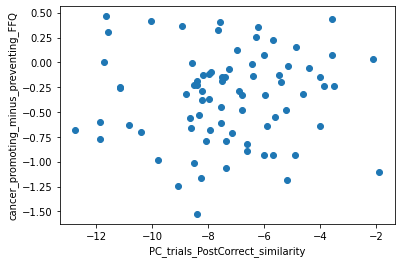

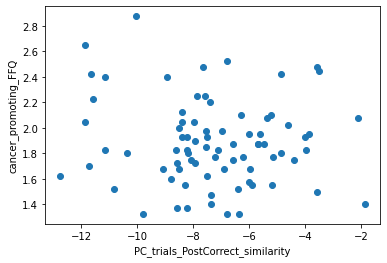

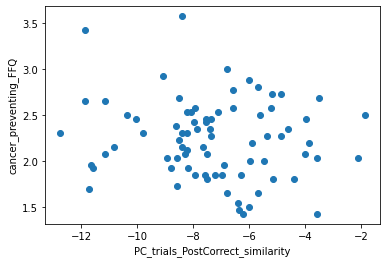

### Female

#### PE_trials_PostError_similarity

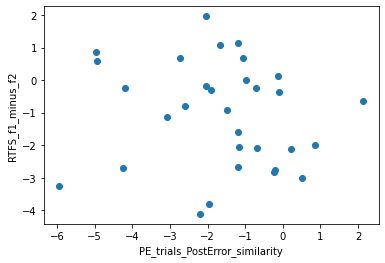

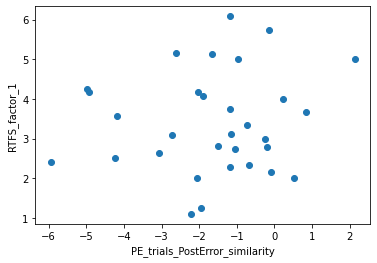

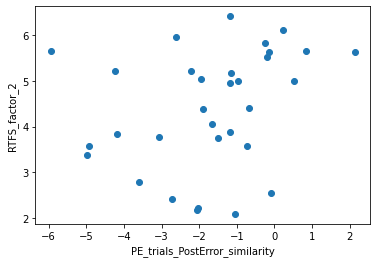

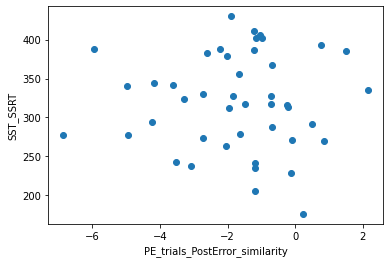

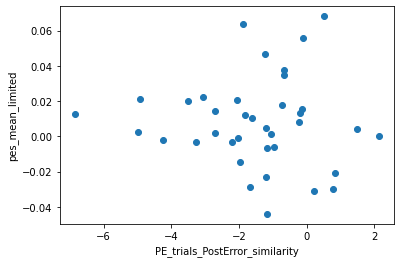

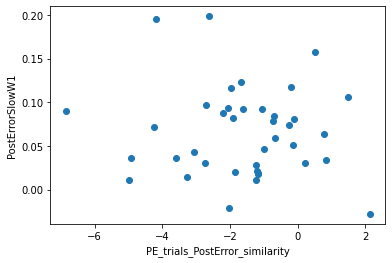

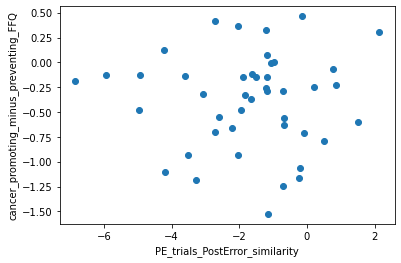

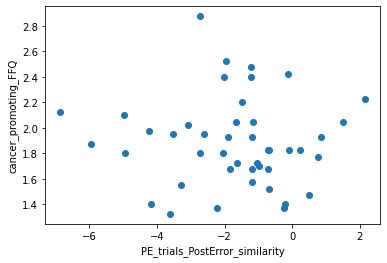

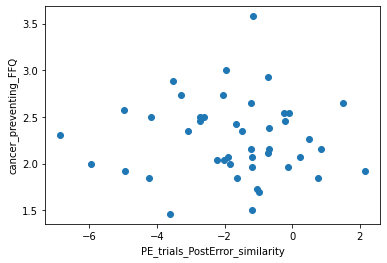

#### PC_trials_PostCorrect_similarity

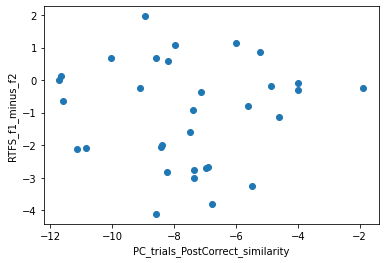

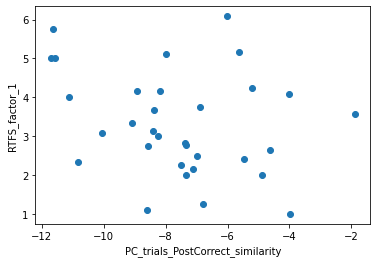

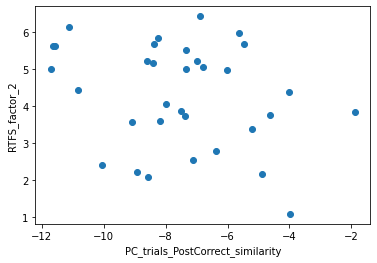

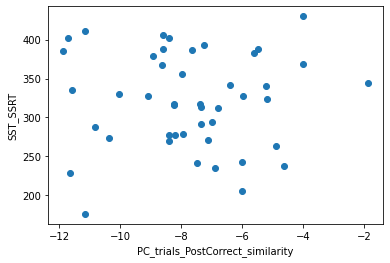

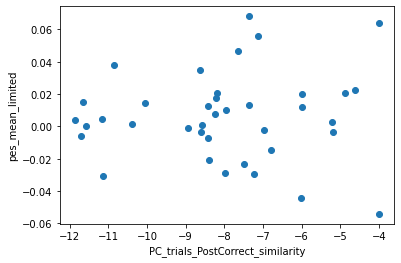

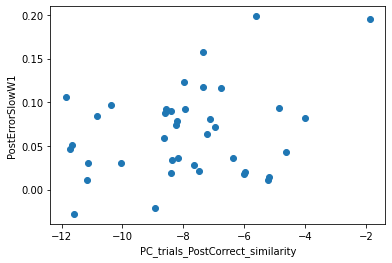

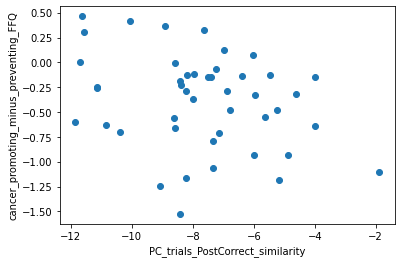

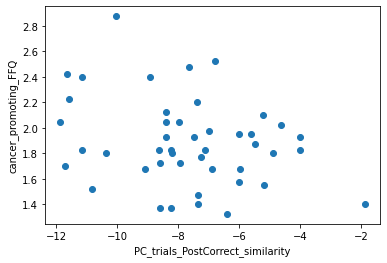

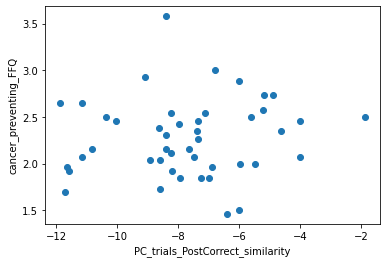

# vmpfc_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_vmpfc_mask.pkl
0.5308641975308642
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_vmpfc_mask.pkl
plotting signatures


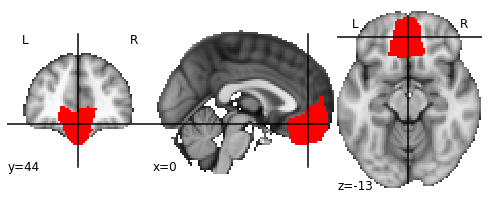

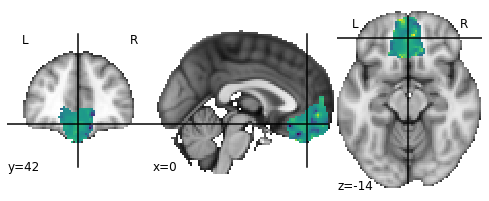

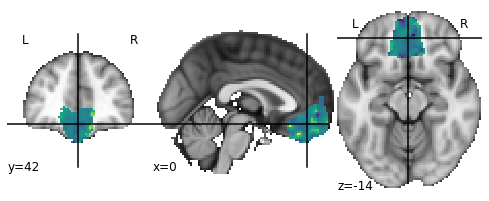

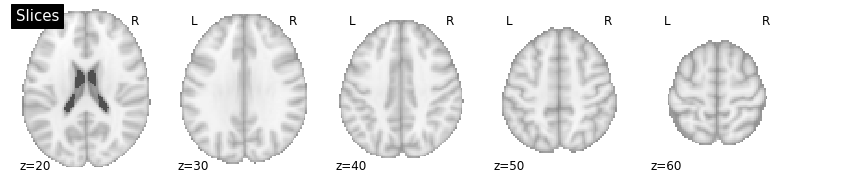

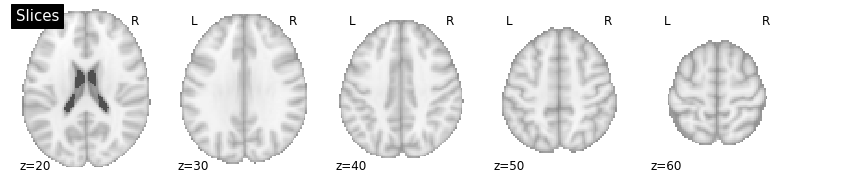

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


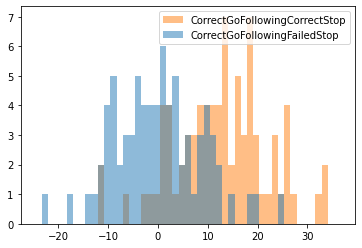

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


12.999535798937606 26.574634617445795 -13.57509881850819 39.5741704163834


-0.07029294780143935 29.17009524234154 -29.24038819014298 29.099802294540098


-12.999535798937606 26.574634617445795 -39.5741704163834 13.57509881850819


0.07029294780143935 29.17009524234154 -29.099802294540098 29.24038819014298


### PE_trials_PostError_similarity

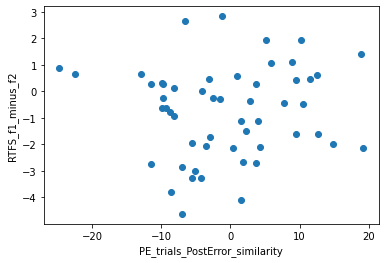

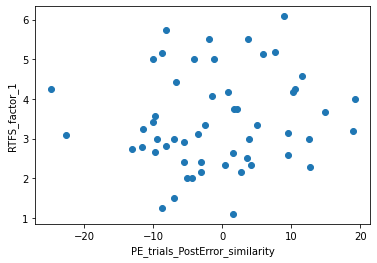

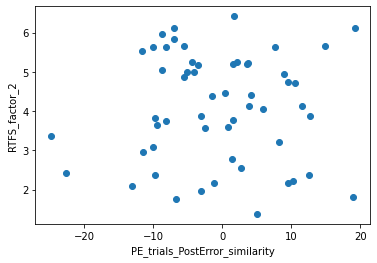

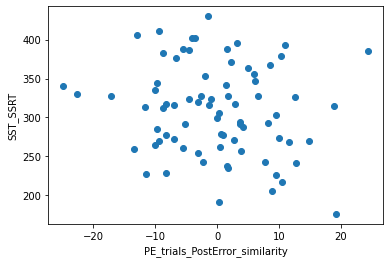

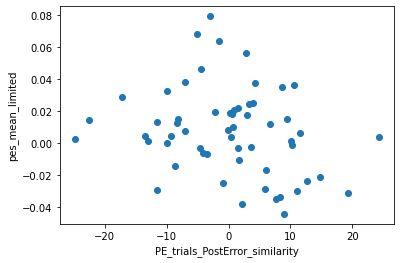

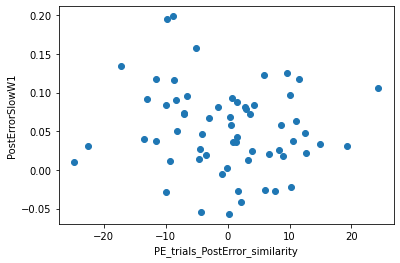

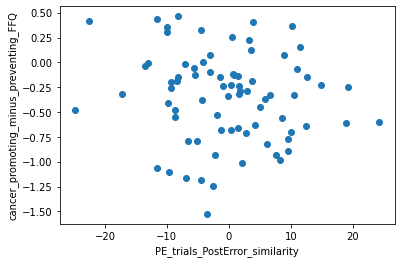

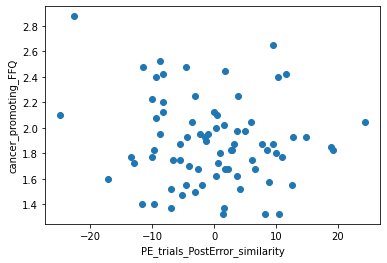

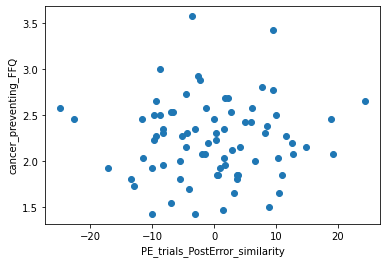

### PC_trials_PostCorrect_similarity

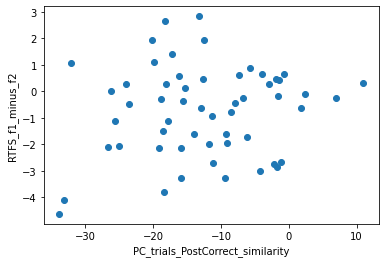

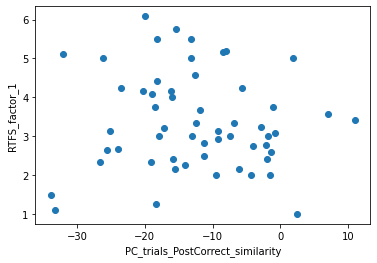

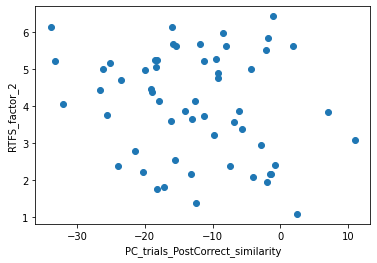

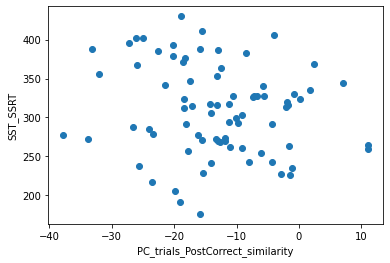

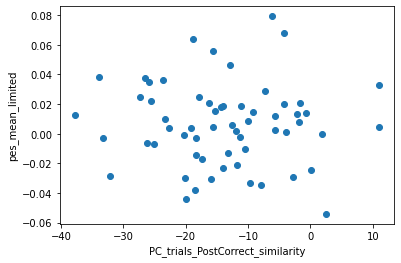

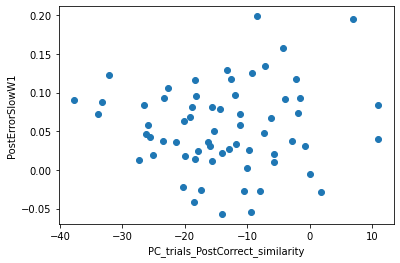

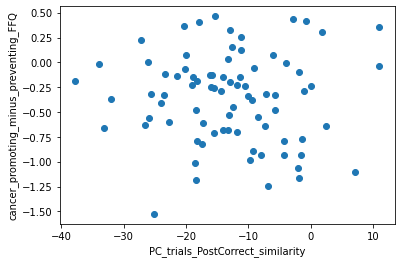

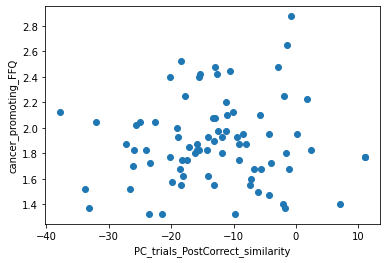

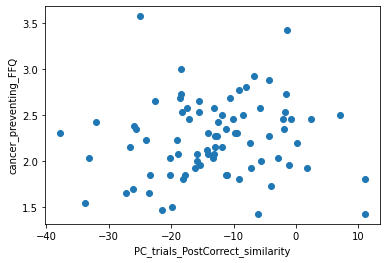

### Female

#### PE_trials_PostError_similarity

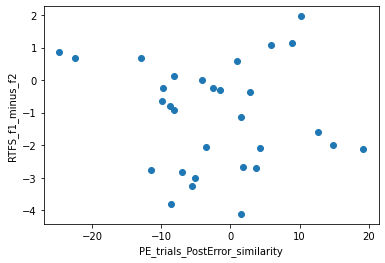

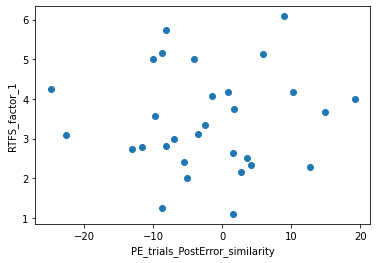

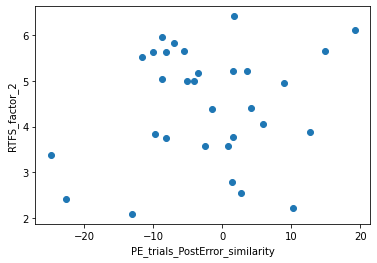

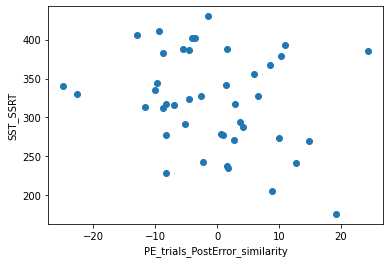

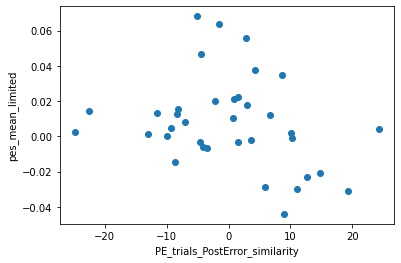

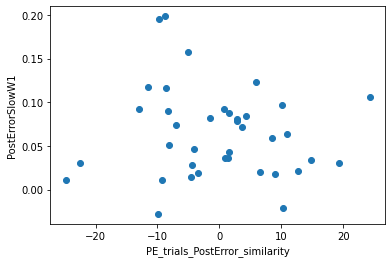

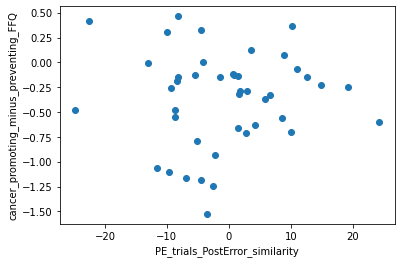

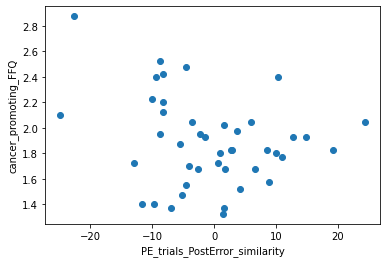

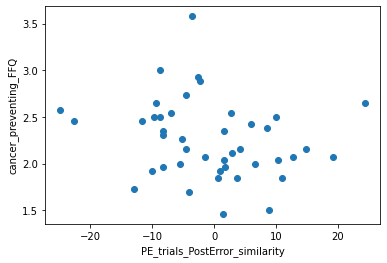

#### PC_trials_PostCorrect_similarity

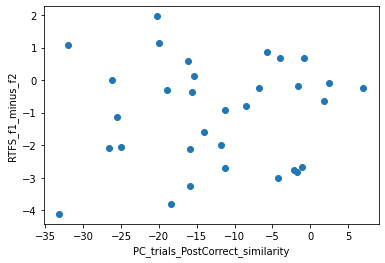

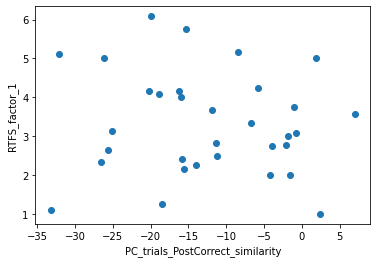

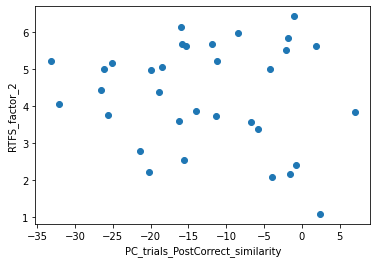

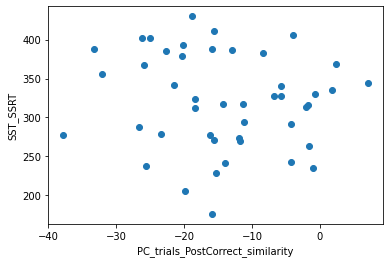

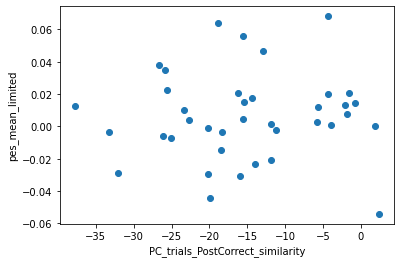

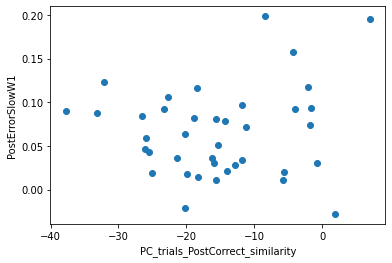

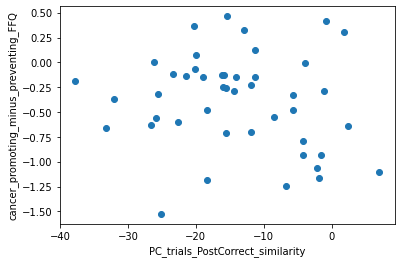

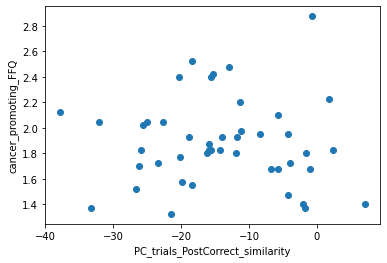

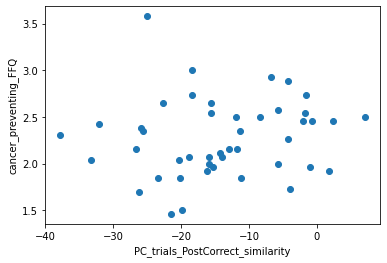

# neurosynth_resting_state_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_resting_state_mask.pkl
0.7777777777777778
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_resting_state_mask.pkl
plotting signatures


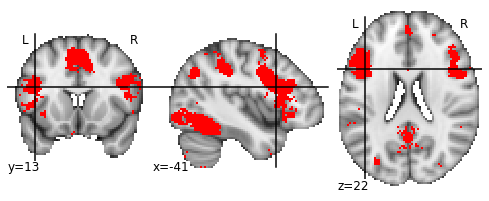

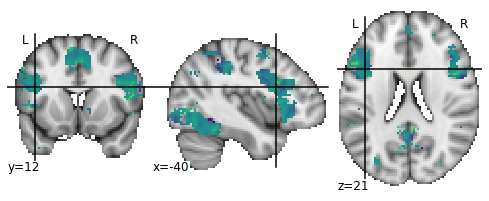

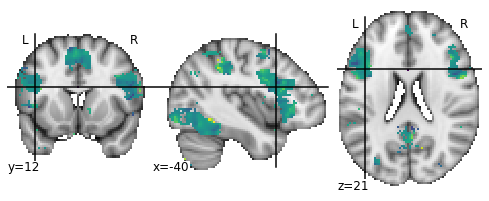

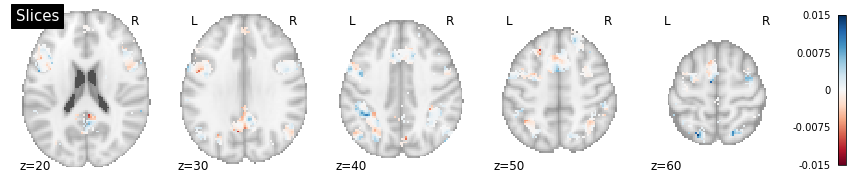

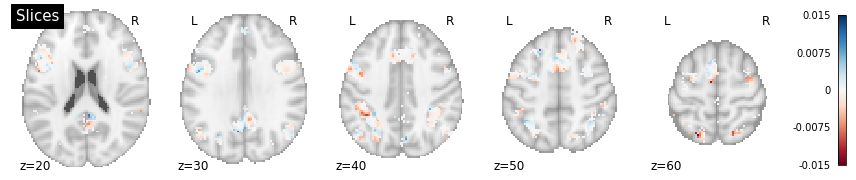

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


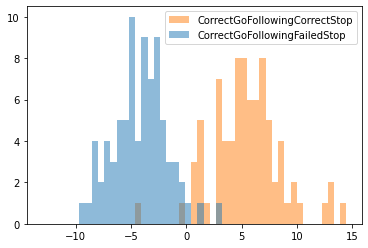

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


5.470541435387608 7.401635805079216 -1.9310943696916087 12.872177240466824


-3.886602174053728 6.576431042924943 -10.46303321697867 2.689828868871215


-5.470541435387608 7.401635805079216 -12.872177240466824 1.9310943696916087


3.886602174053728 6.576431042924943 -2.689828868871215 10.46303321697867


### PE_trials_PostError_similarity

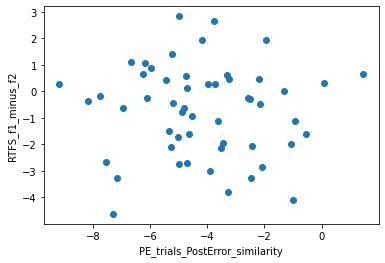

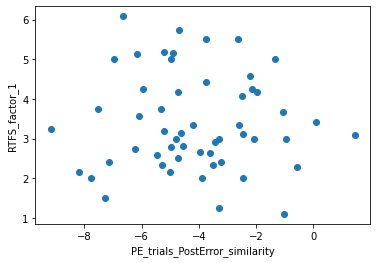

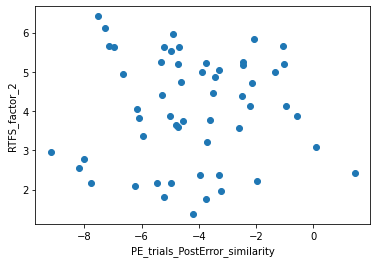

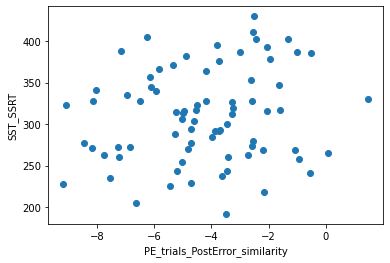

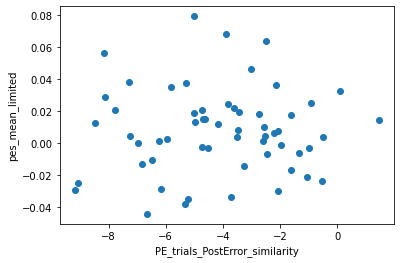

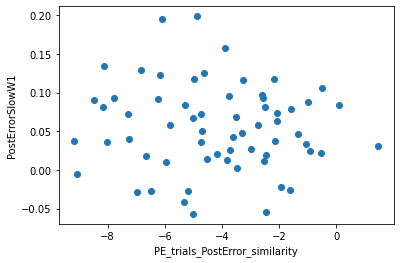

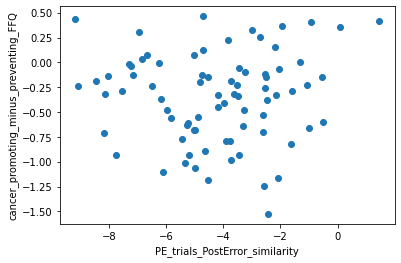

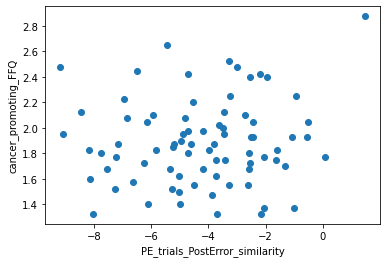

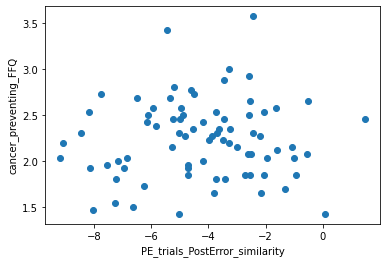

### PC_trials_PostCorrect_similarity

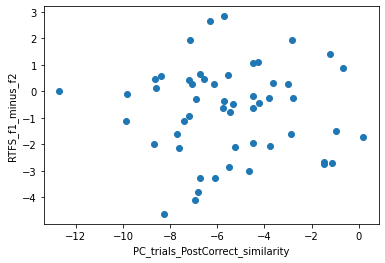

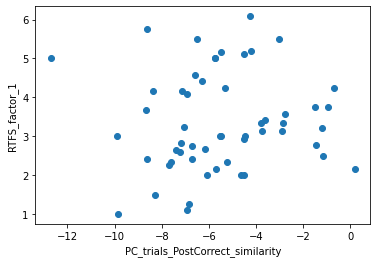

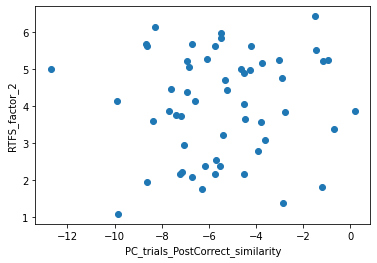

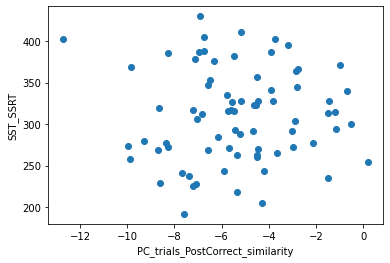

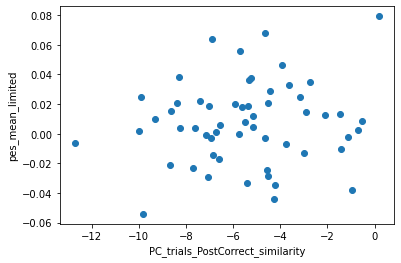

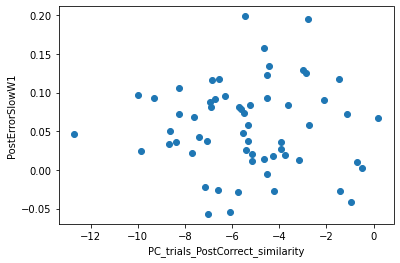

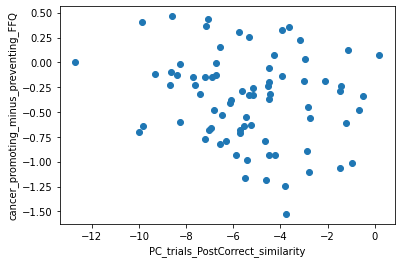

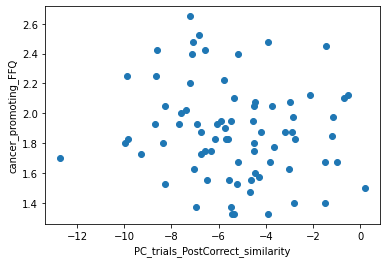

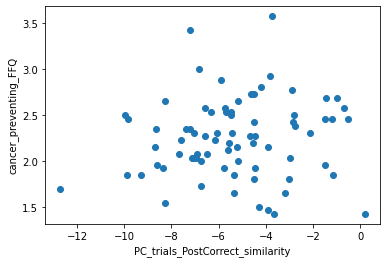

### Female

#### PE_trials_PostError_similarity

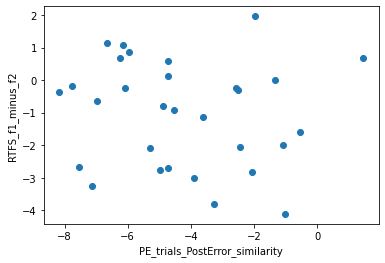

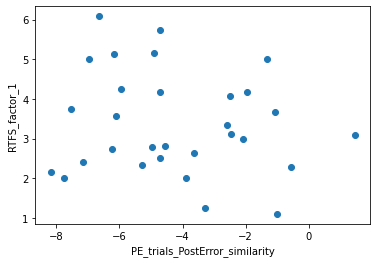

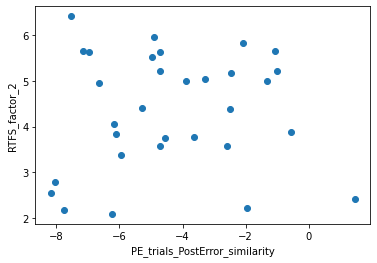

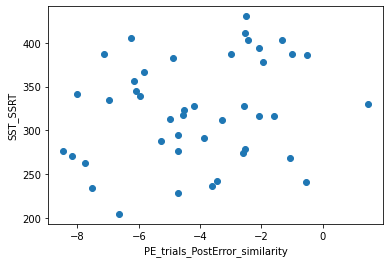

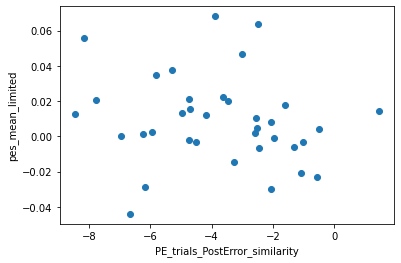

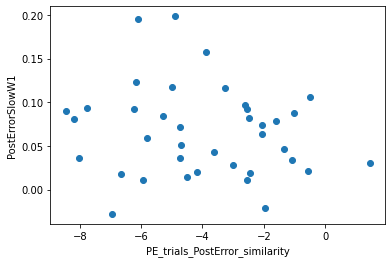

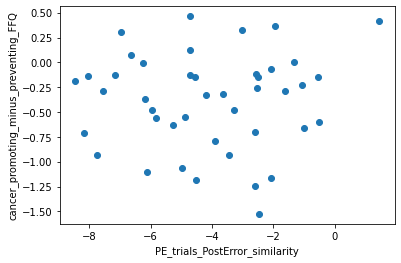

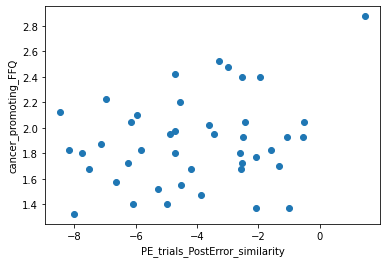

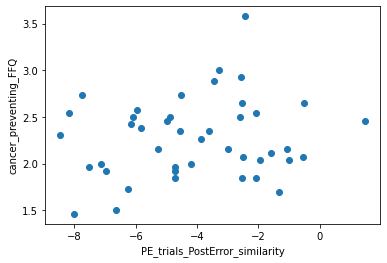

#### PC_trials_PostCorrect_similarity

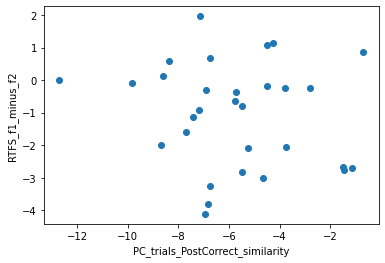

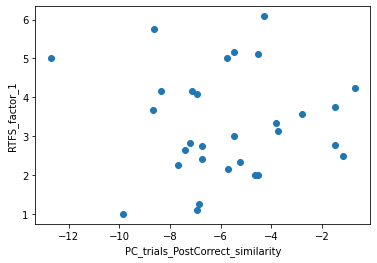

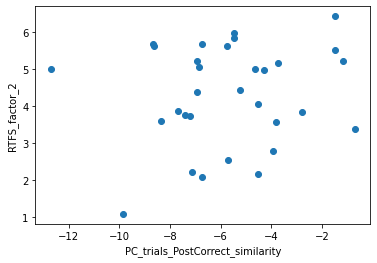

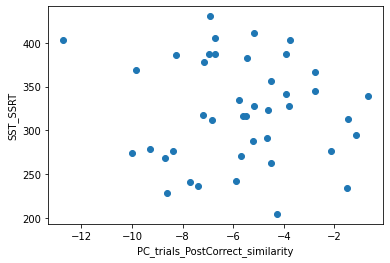

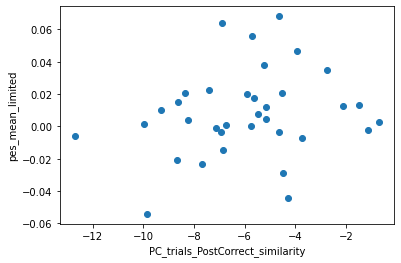

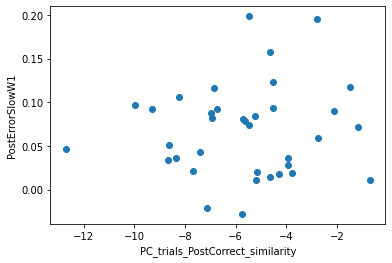

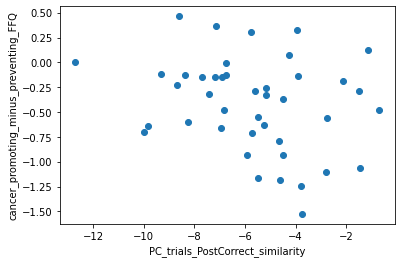

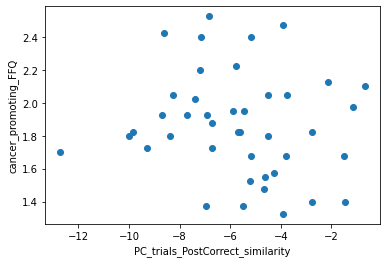

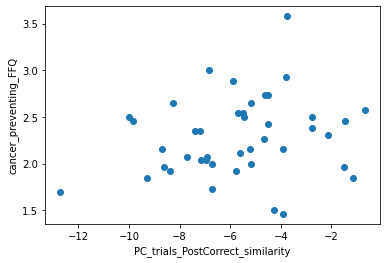

# neurosynth_vmpfc_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_vmpfc_mask.pkl
0.6851851851851852
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_vmpfc_mask.pkl
plotting signatures


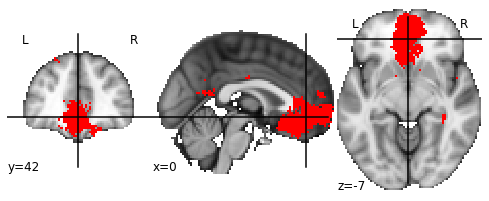

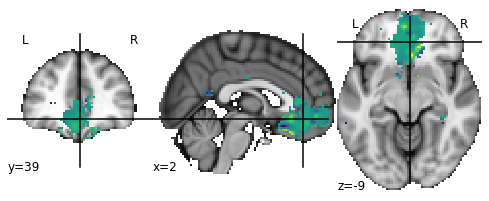

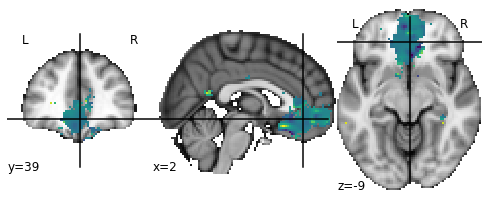

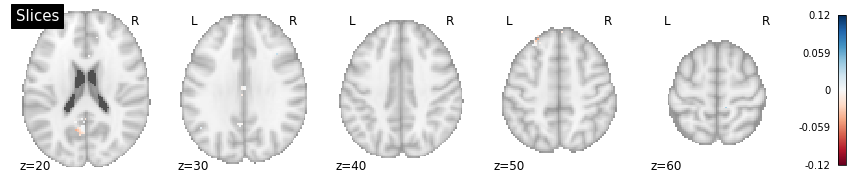

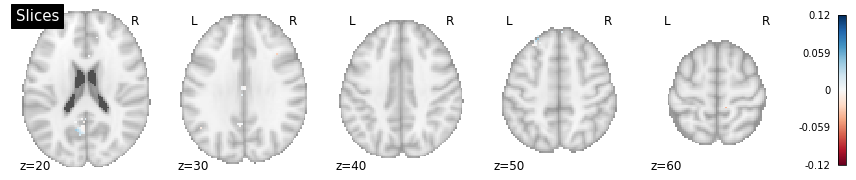

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


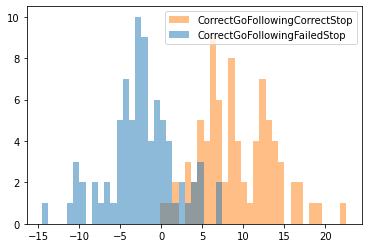

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


8.681308200951513 14.89693076838759 -6.2156225674360766 23.578238969339104


-2.626943239043872 9.609036180282645 -12.235979419326517 6.982092941238774


-8.681308200951513 14.89693076838759 -23.578238969339104 6.2156225674360766


2.626943239043872 9.609036180282645 -6.982092941238774 12.235979419326517


### PE_trials_PostError_similarity

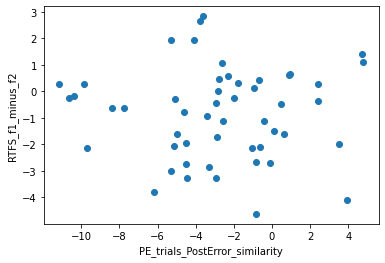

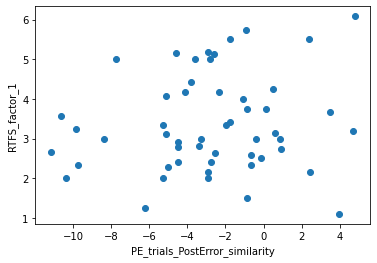

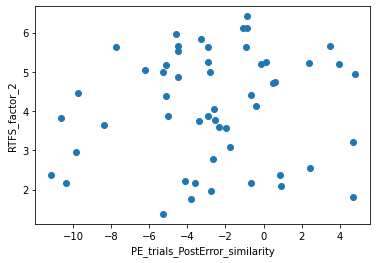

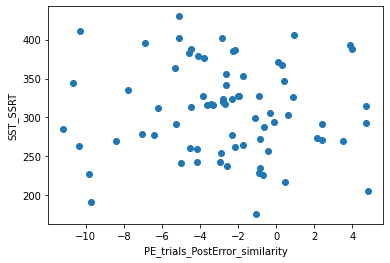

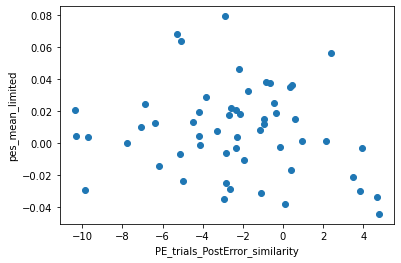

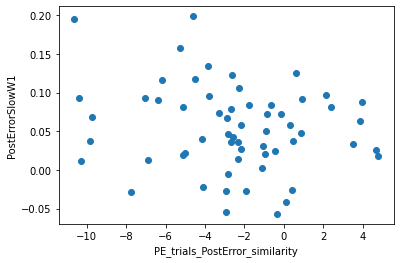

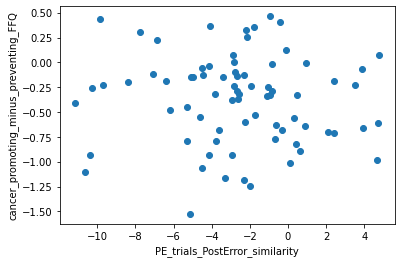

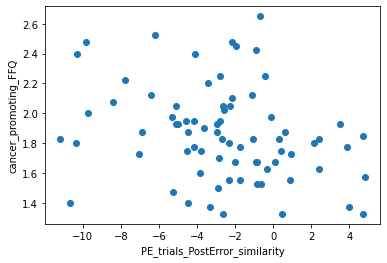

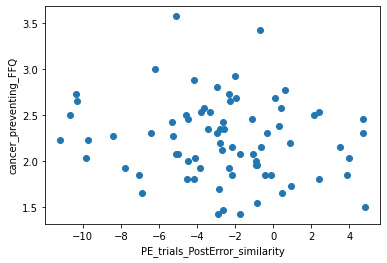

### PC_trials_PostCorrect_similarity

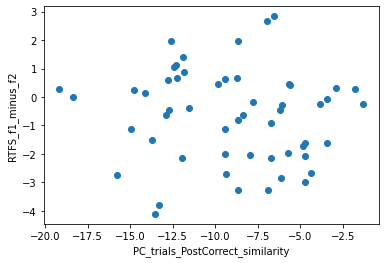

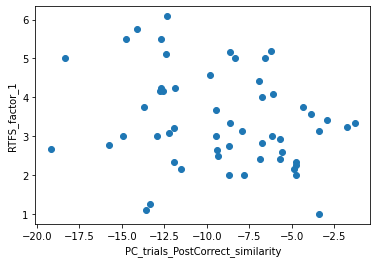

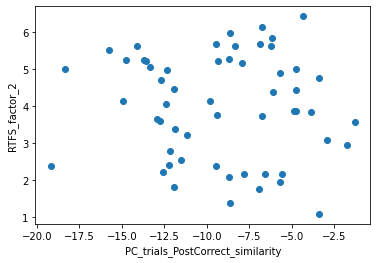

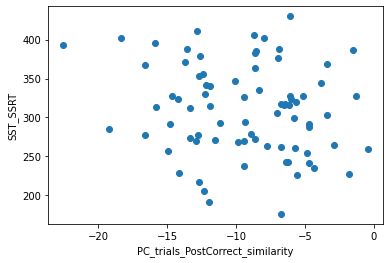

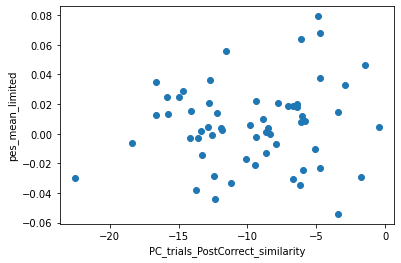

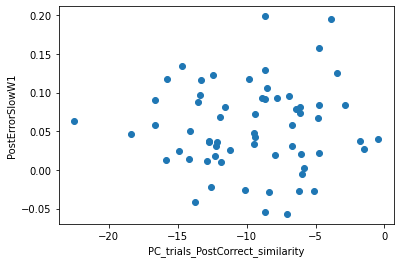

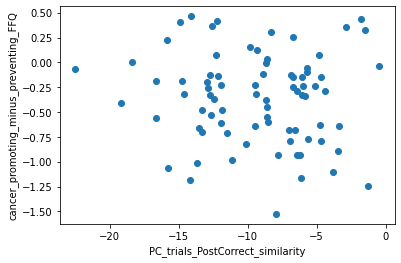

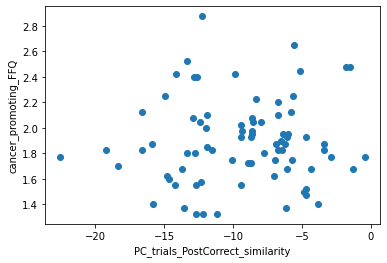

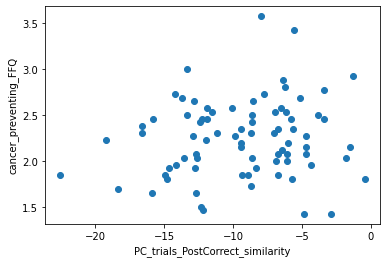

### Female

#### PE_trials_PostError_similarity

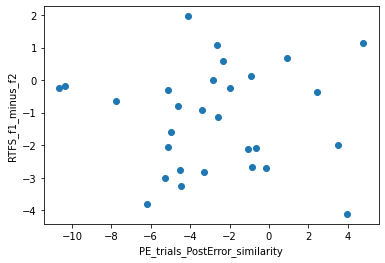

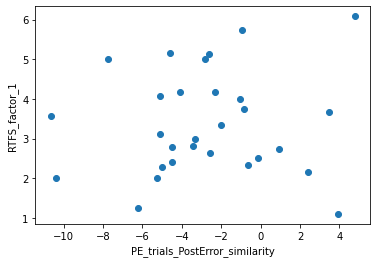

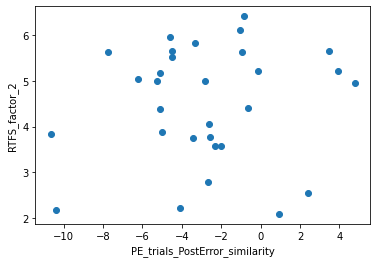

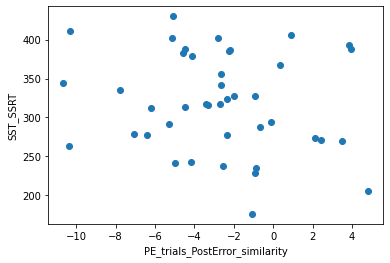

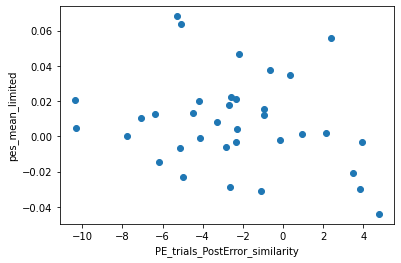

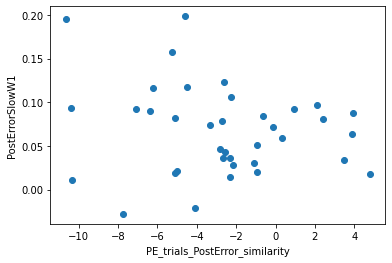

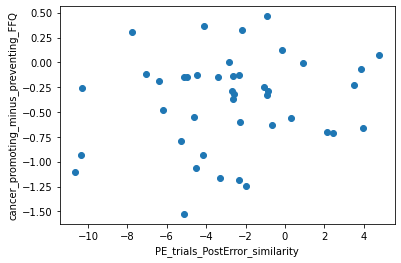

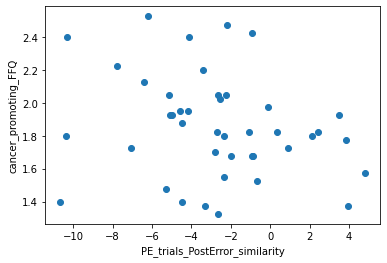

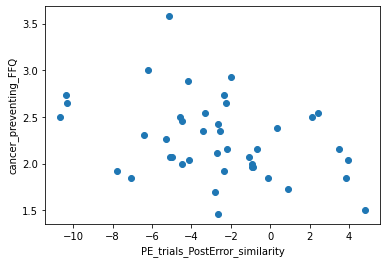

#### PC_trials_PostCorrect_similarity

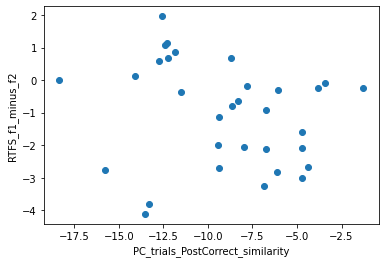

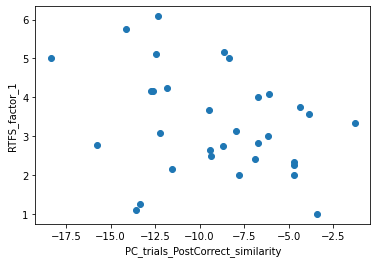

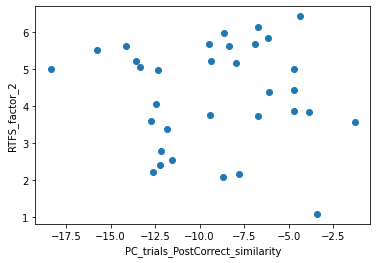

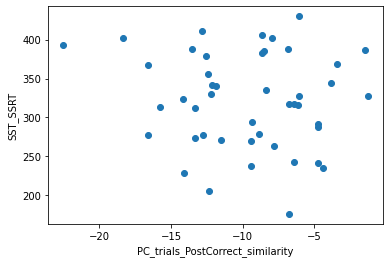

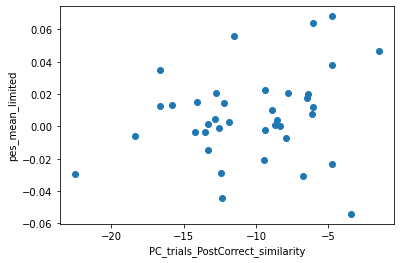

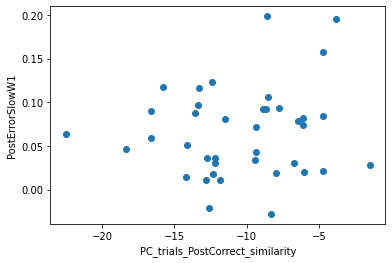

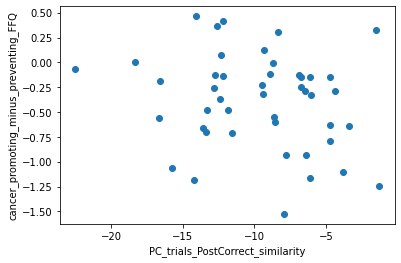

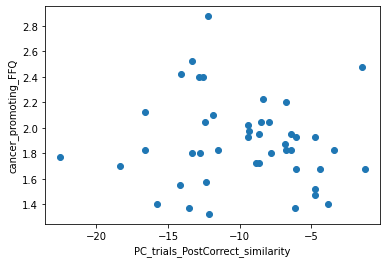

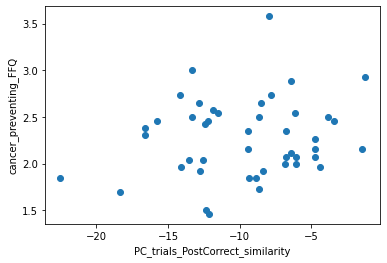

# neurosynth_dlpfc_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_dlpfc_mask.pkl
0.6172839506172839
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_dlpfc_mask.pkl
plotting signatures


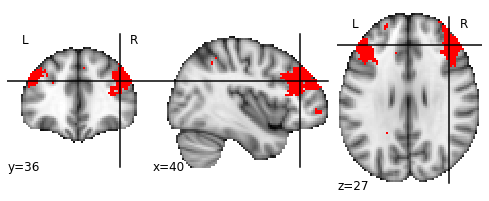

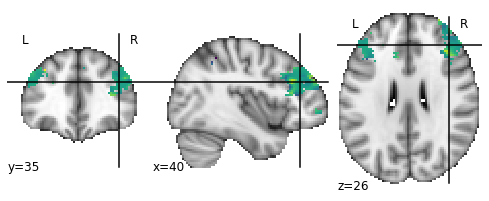

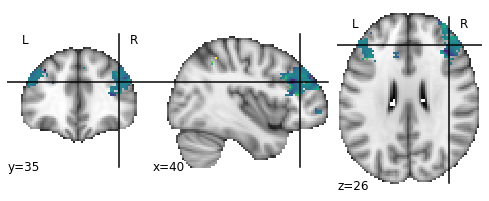

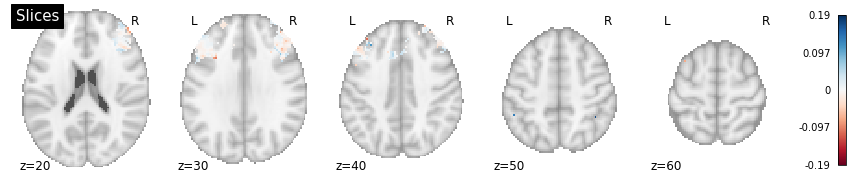

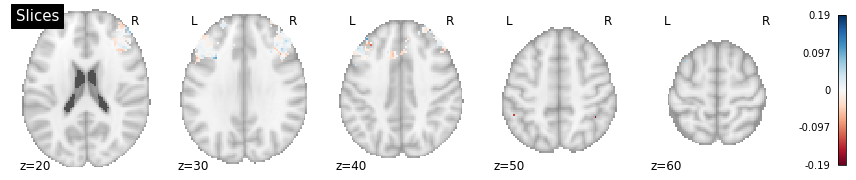

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


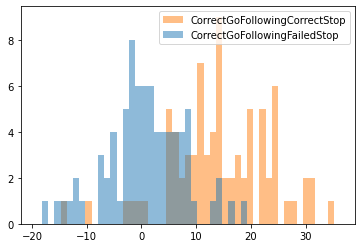

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


14.054854408869287 27.90605114054494 -13.851196731675651 41.96090554941423


0.5413853188535305 18.48526128877542 -17.943875969921887 19.02664660762895


-14.054854408869287 27.90605114054494 -41.96090554941423 13.851196731675651


-0.5413853188535305 18.48526128877542 -19.02664660762895 17.943875969921887


### PE_trials_PostError_similarity

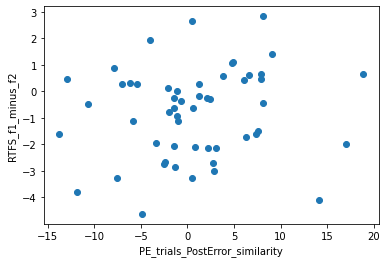

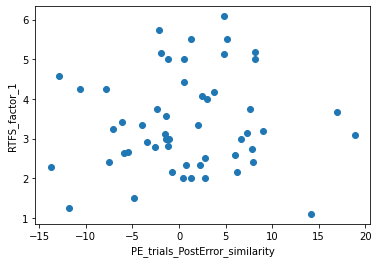

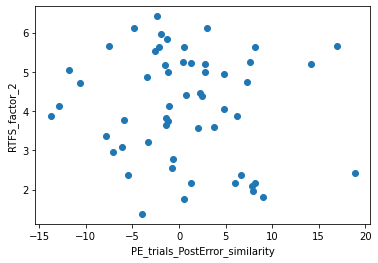

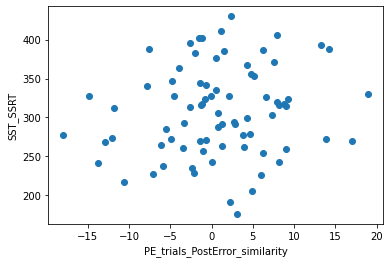

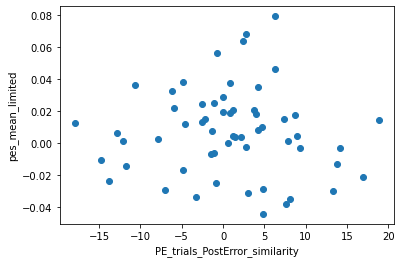

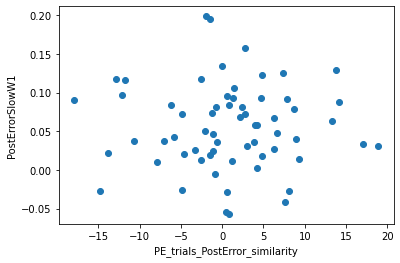

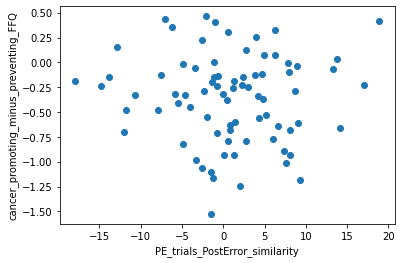

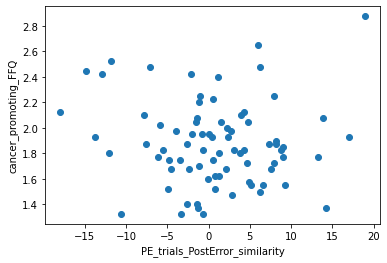

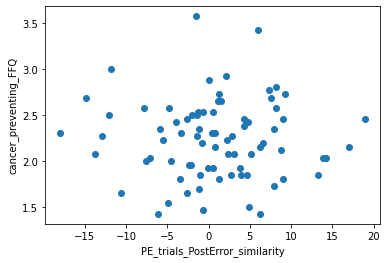

### PC_trials_PostCorrect_similarity

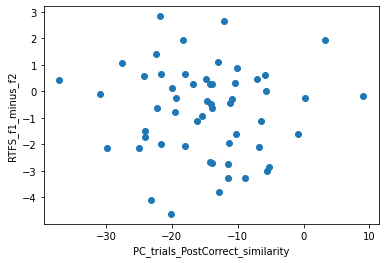

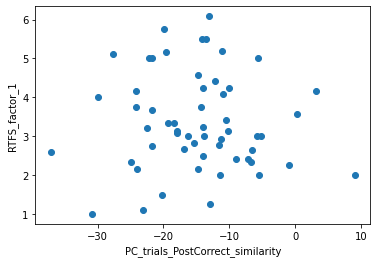

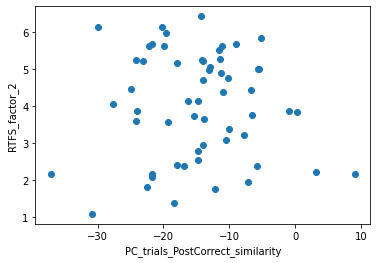

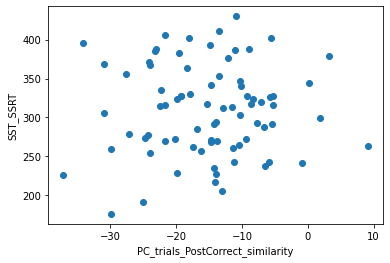

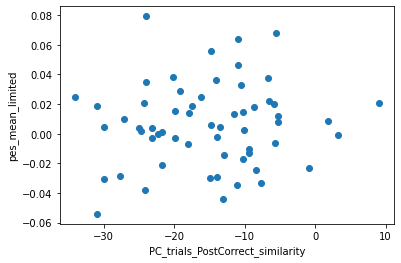

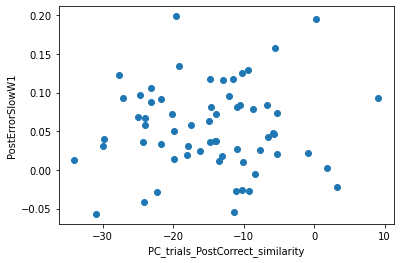

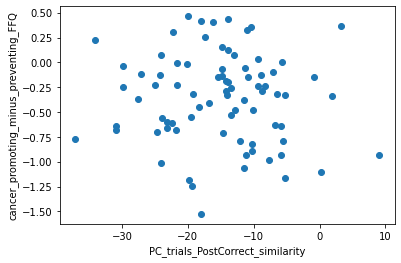

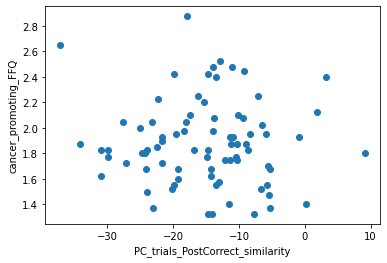

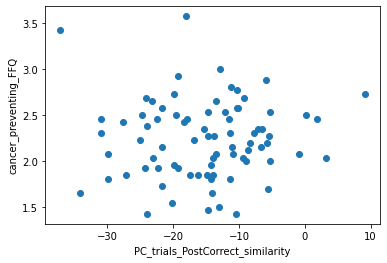

### Female

#### PE_trials_PostError_similarity

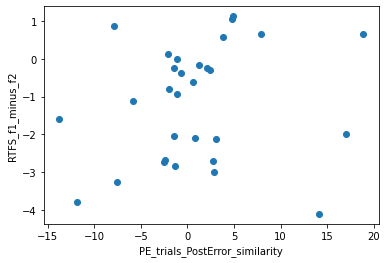

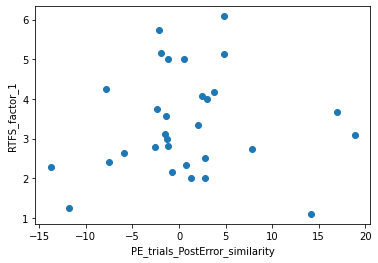

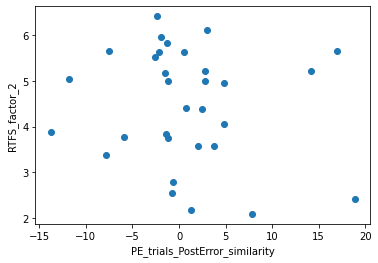

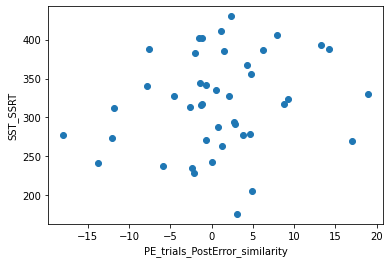

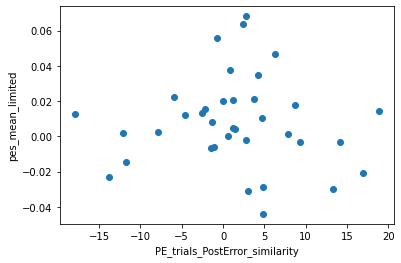

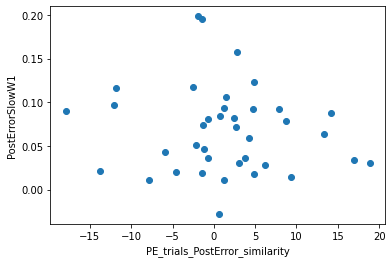

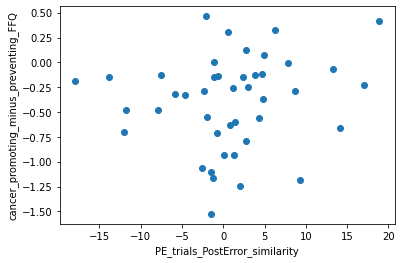

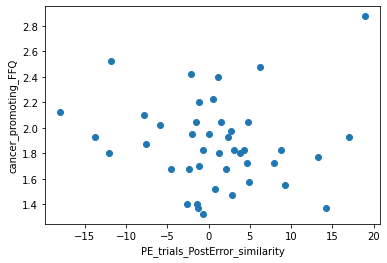

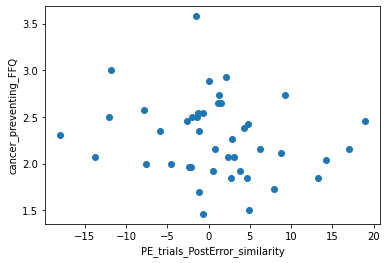

#### PC_trials_PostCorrect_similarity

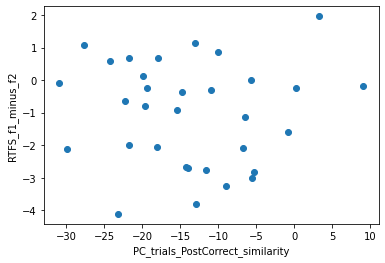

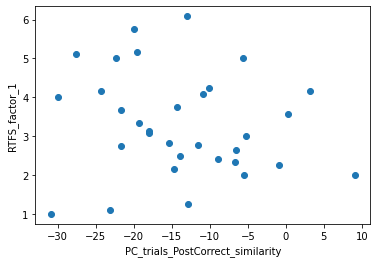

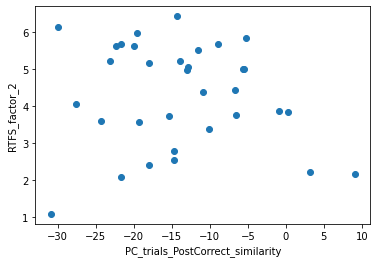

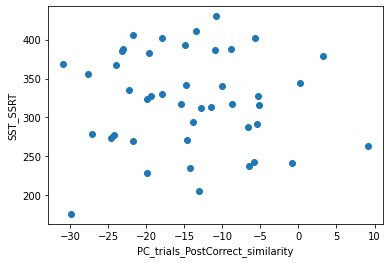

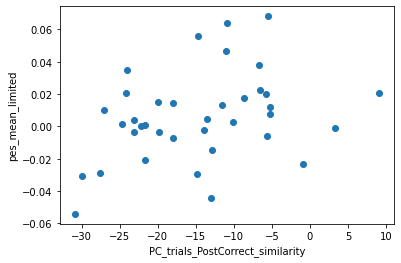

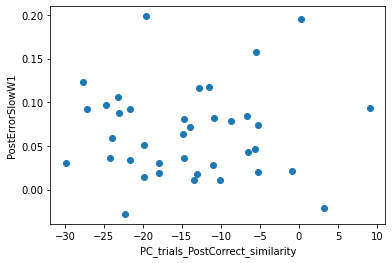

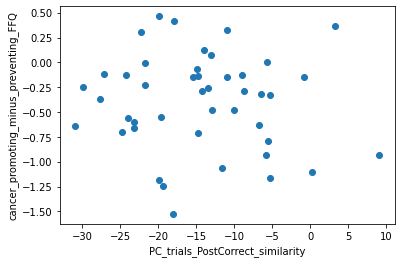

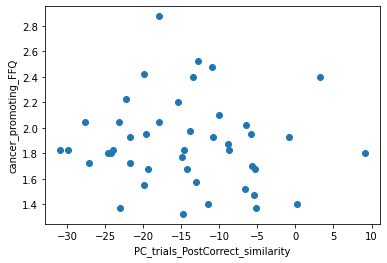

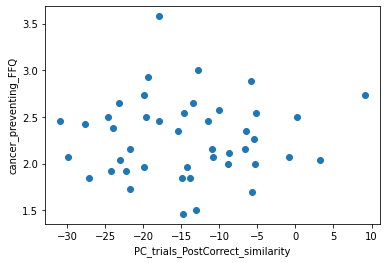

# neurosynth_negative_emotions_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_negative_emotions_mask.pkl
0.6111111111111112
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_negative_emotions_mask.pkl
plotting signatures


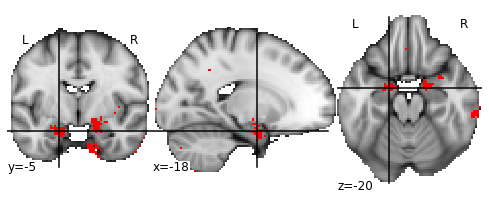

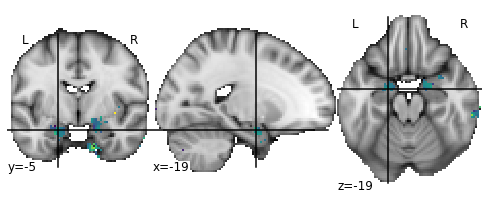

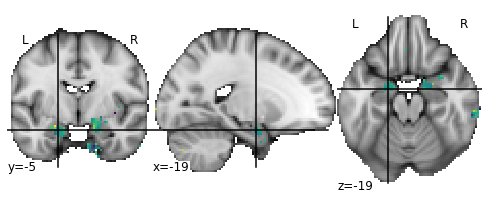

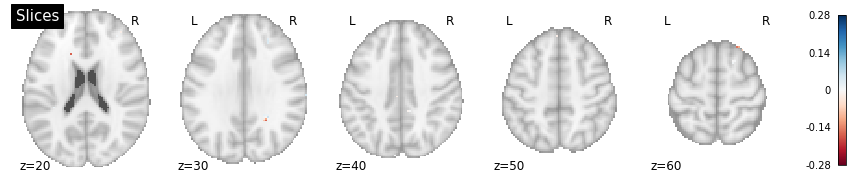

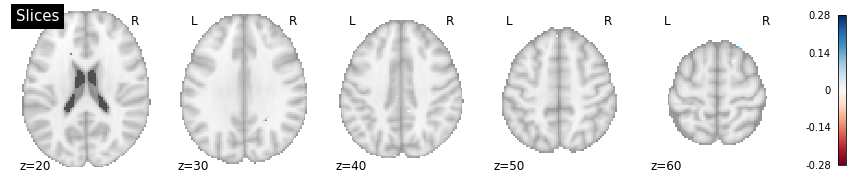

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


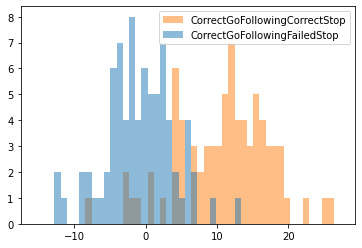

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


11.90211364255374 19.624286150346474 -7.722172507792735 31.526399792900214


-0.881749664042365 14.18931211544186 -15.071061779484225 13.307562451399495


-11.90211364255374 19.624286150346474 -31.526399792900214 7.722172507792735


0.881749664042365 14.18931211544186 -13.307562451399495 15.071061779484225


### PE_trials_PostError_similarity

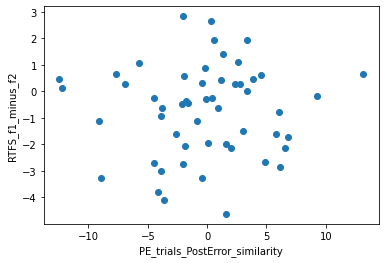

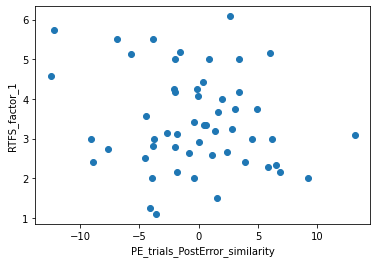

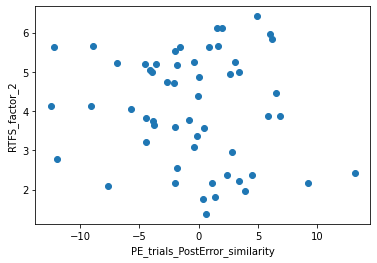

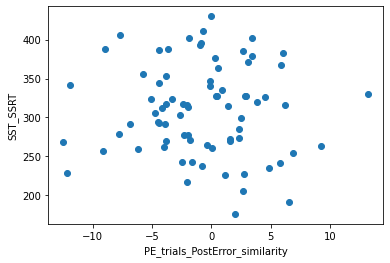

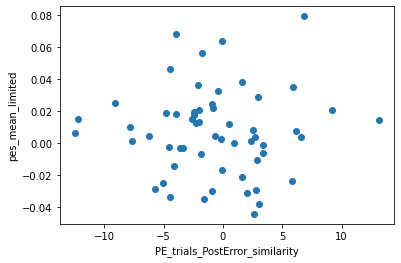

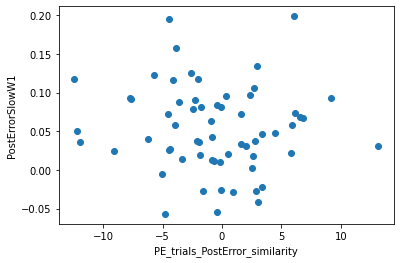

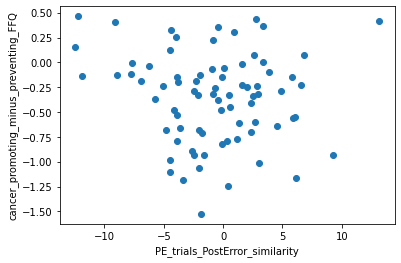

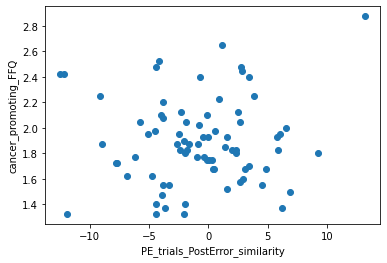

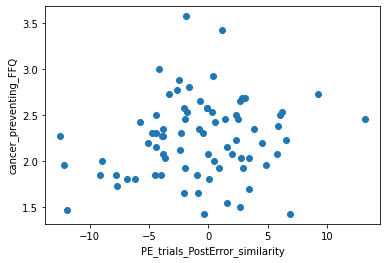

### PC_trials_PostCorrect_similarity

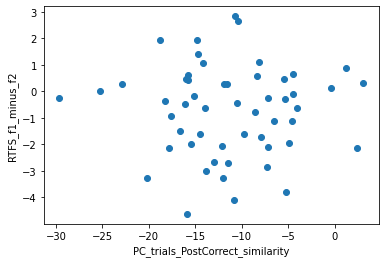

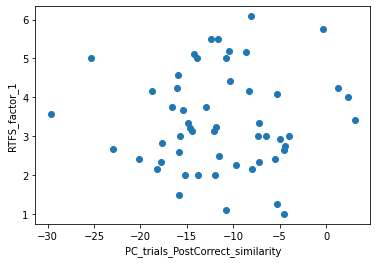

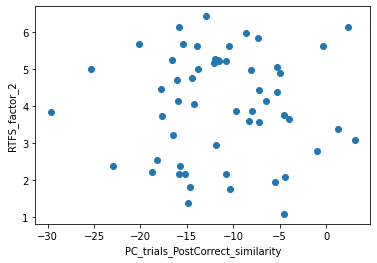

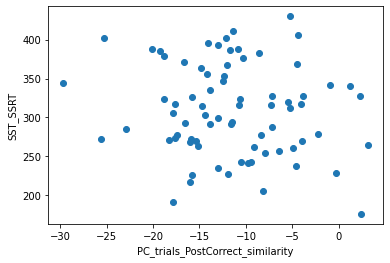

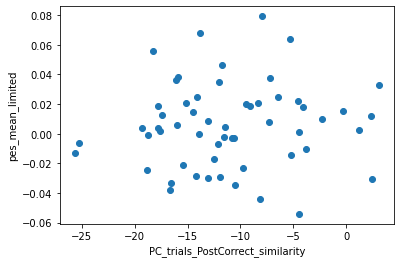

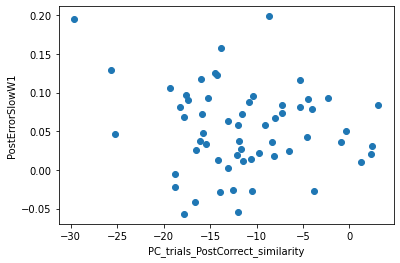

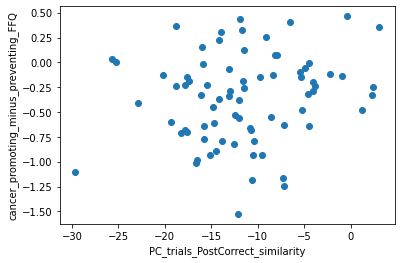

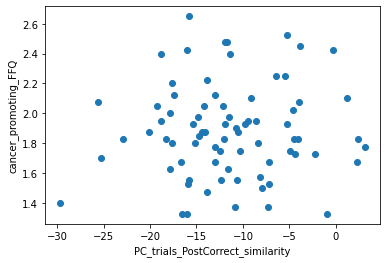

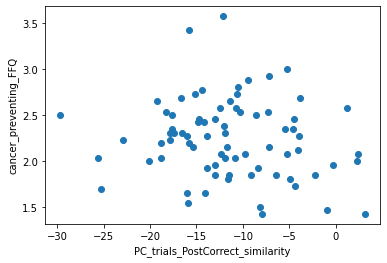

### Female

#### PE_trials_PostError_similarity

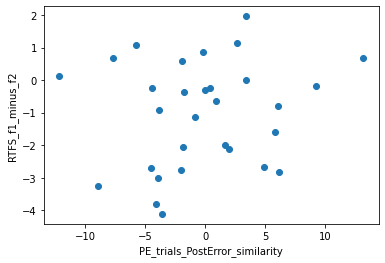

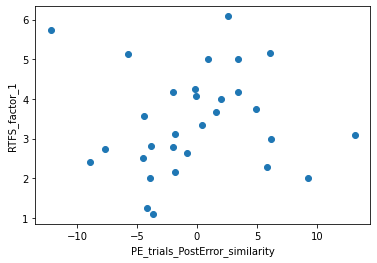

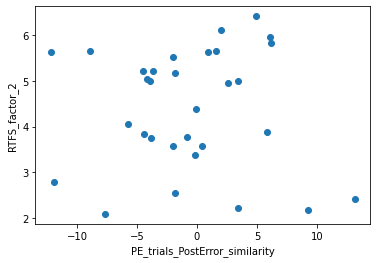

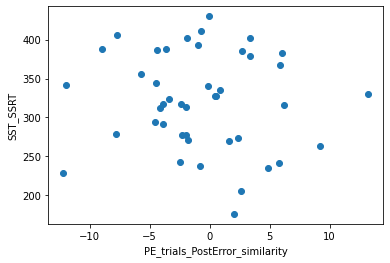

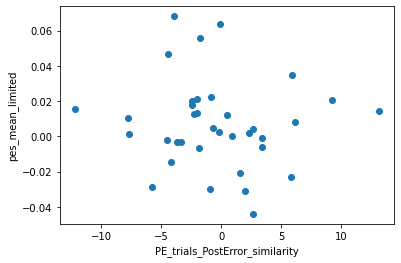

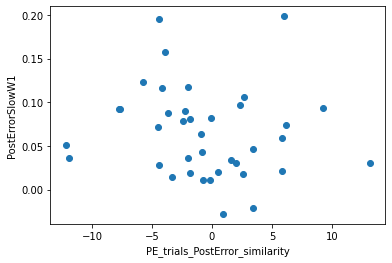

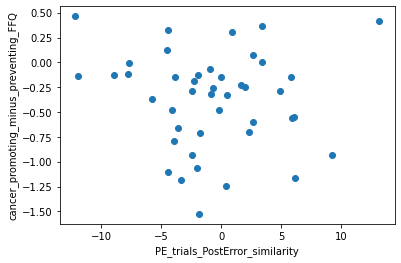

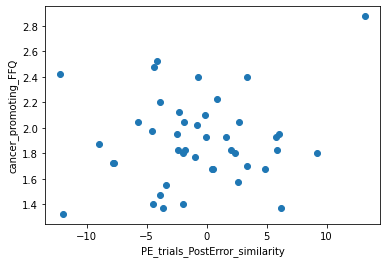

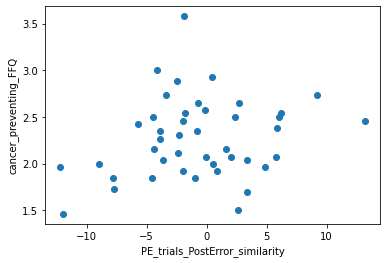

#### PC_trials_PostCorrect_similarity

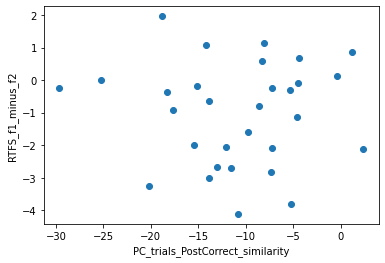

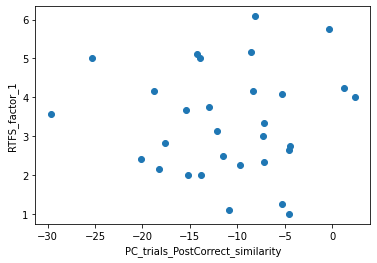

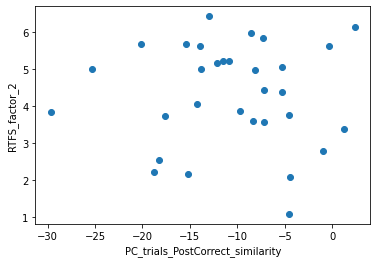

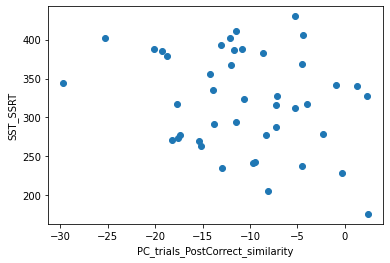

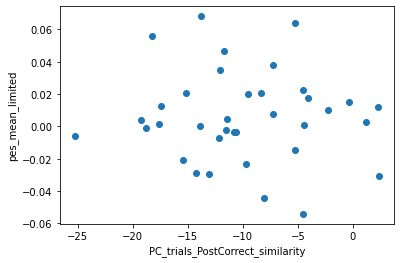

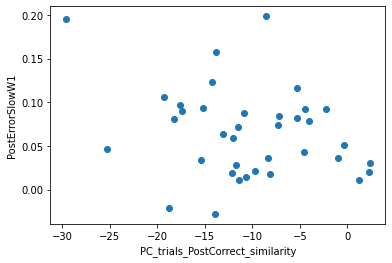

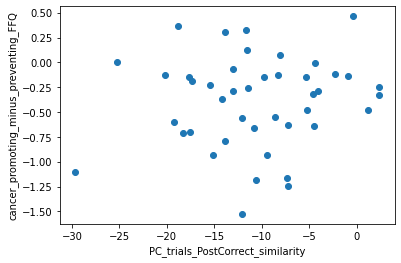

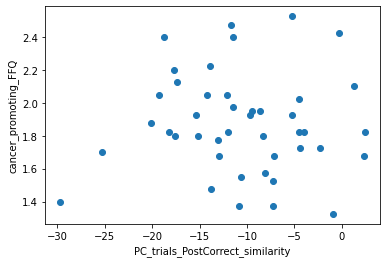

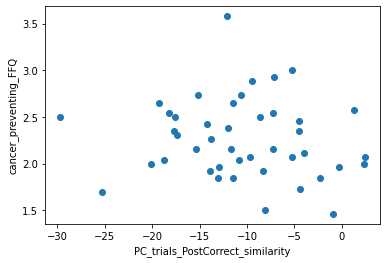

# neurosynth_negative_affect_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_negative_affect_mask.pkl
0.6481481481481481
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_negative_affect_mask.pkl
plotting signatures


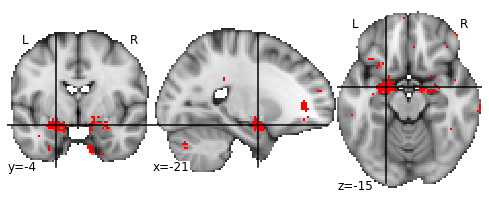

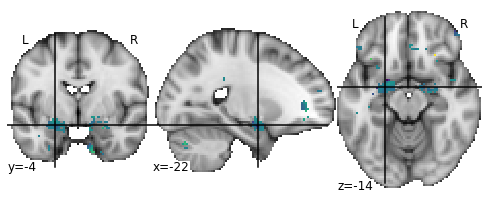

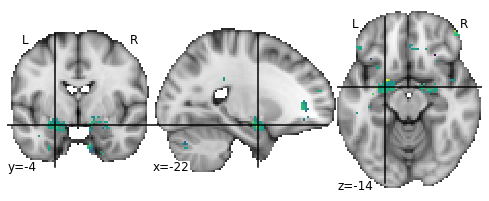

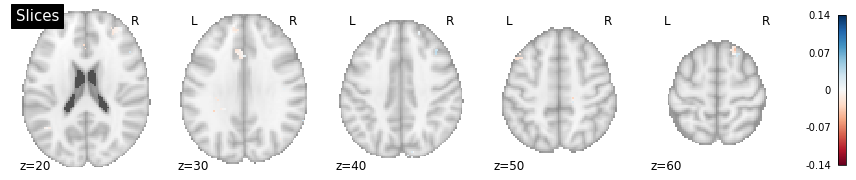

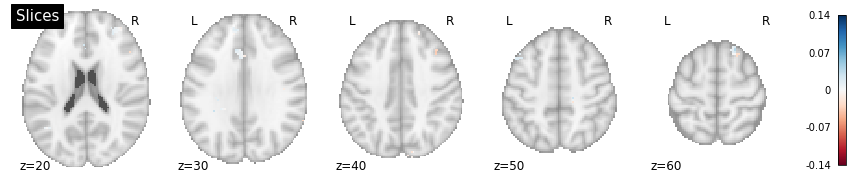

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


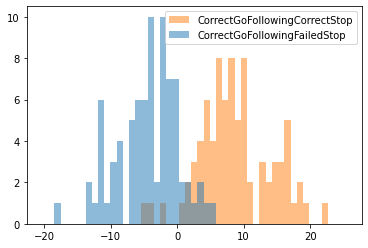

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


8.20947600420657 15.524837274909647 -7.315361270703077 23.734313279116215


-4.10464011525852 13.214759483281782 -17.3193995985403 9.110119368023263


-8.20947600420657 15.524837274909647 -23.734313279116215 7.315361270703077


4.10464011525852 13.214759483281782 -9.110119368023263 17.3193995985403


### PE_trials_PostError_similarity

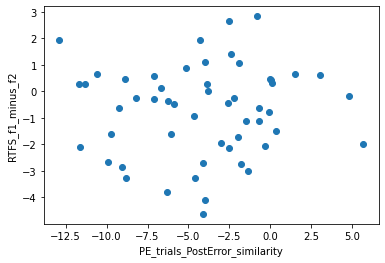

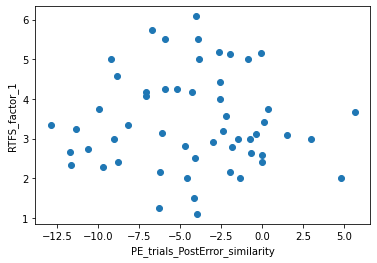

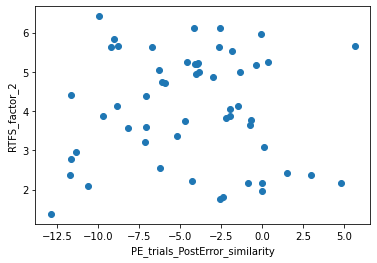

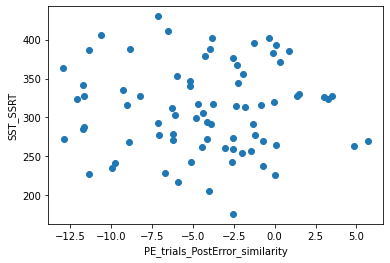

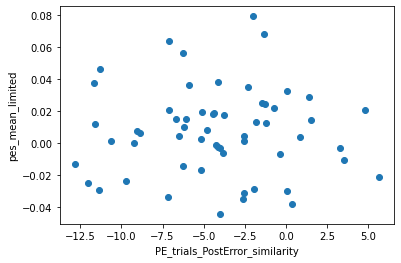

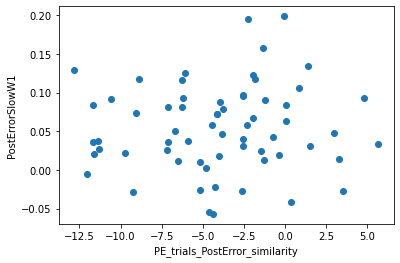

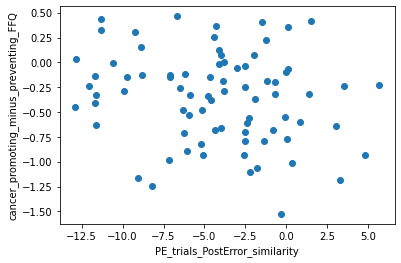

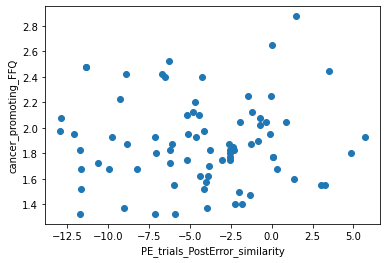

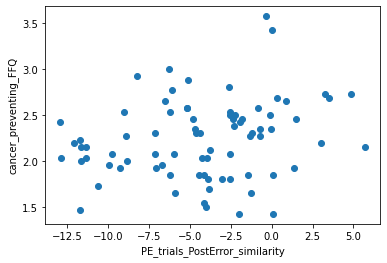

### PC_trials_PostCorrect_similarity

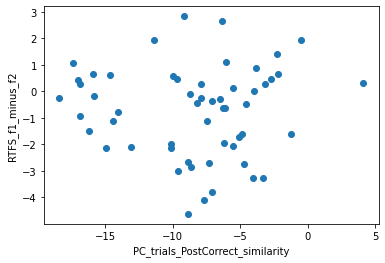

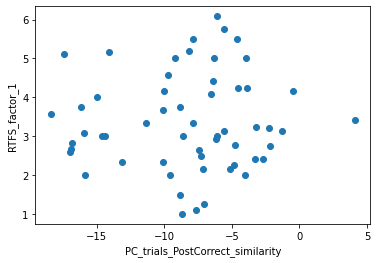

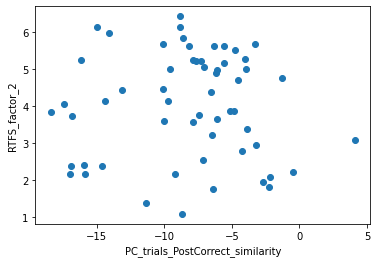

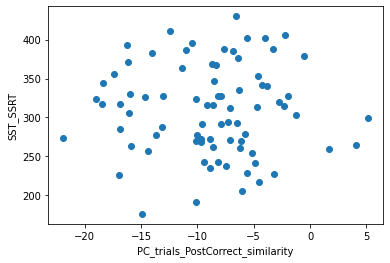

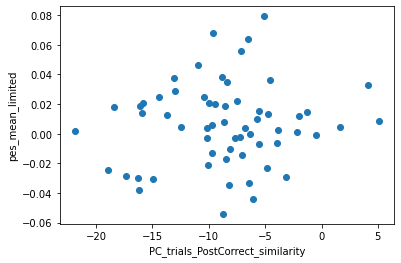

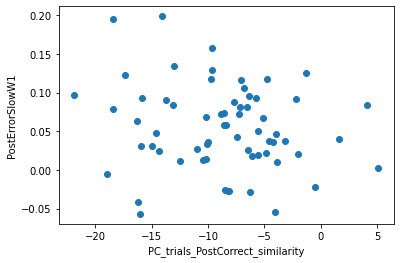

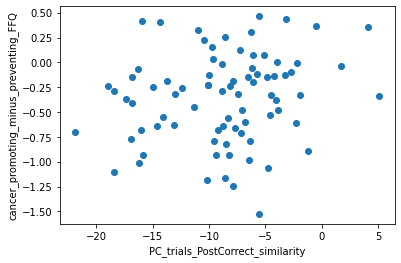

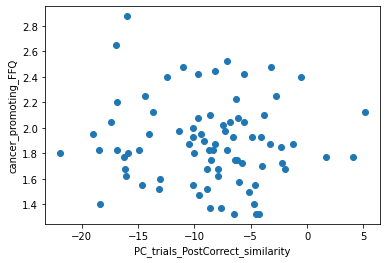

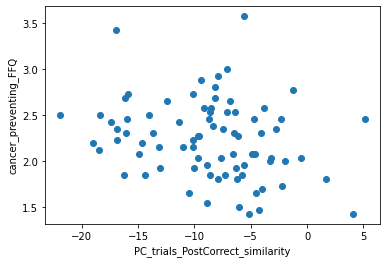

### Female

#### PE_trials_PostError_similarity

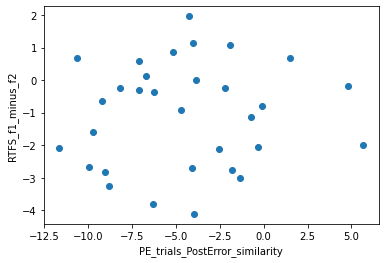

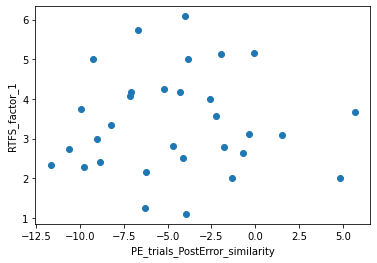

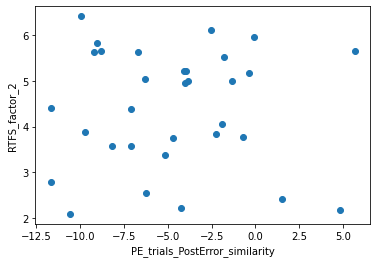

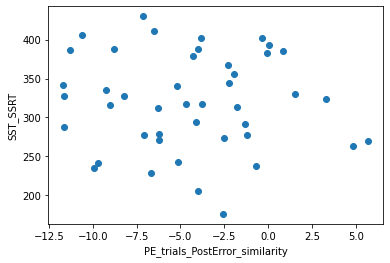

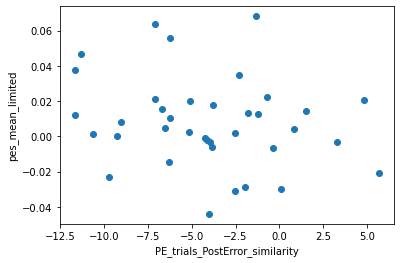

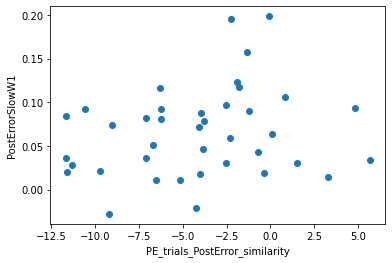

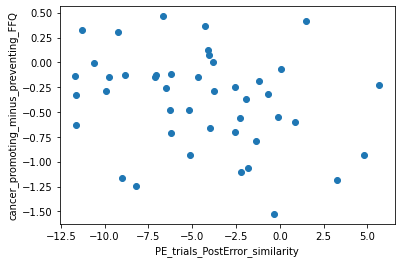

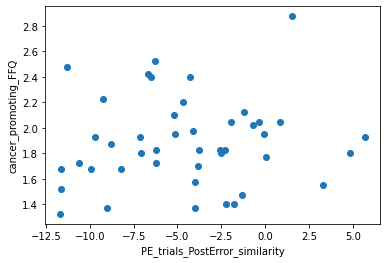

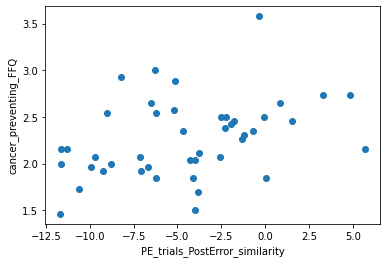

#### PC_trials_PostCorrect_similarity

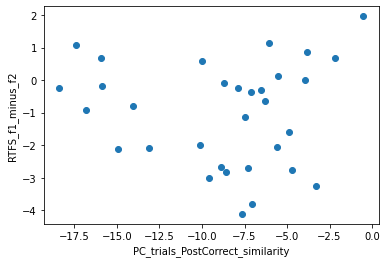

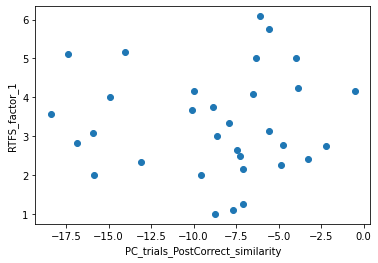

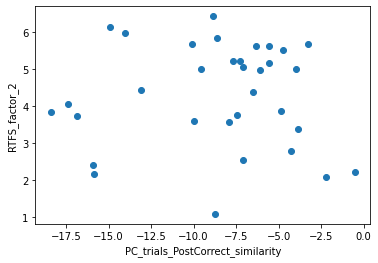

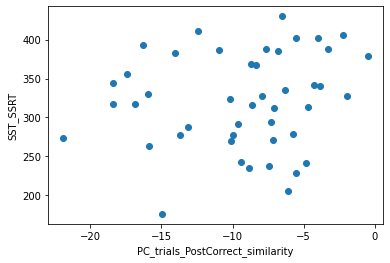

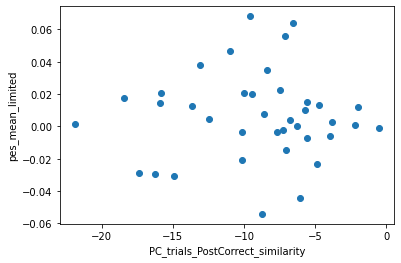

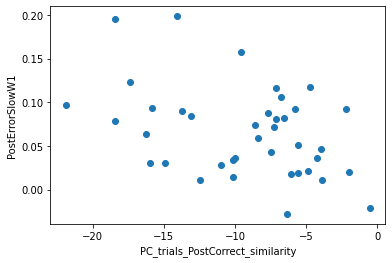

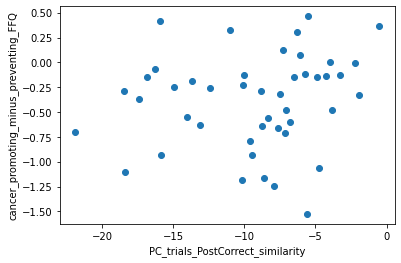

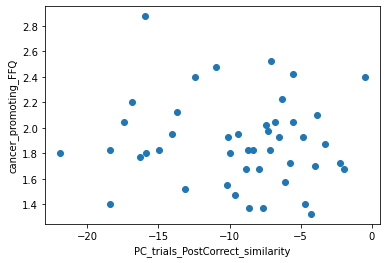

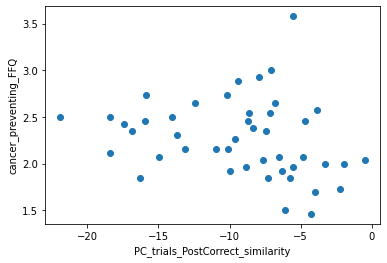

# neurosynth_self_referential_mask

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_self_referential_mask.pkl
0.6666666666666666
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_self_referential_mask.pkl
plotting signatures


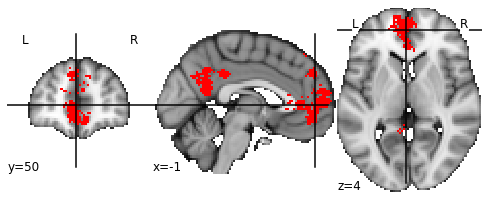

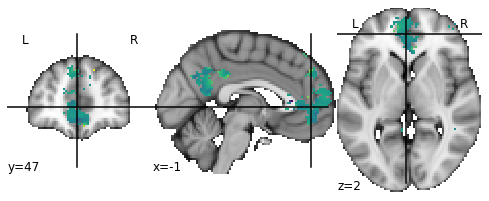

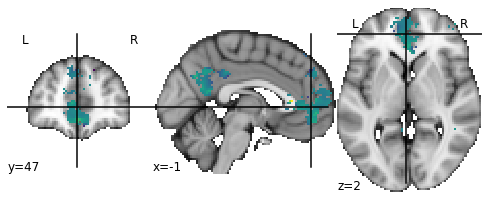

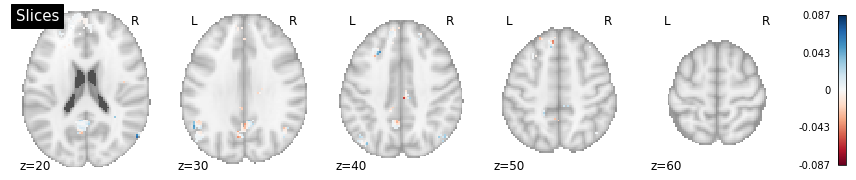

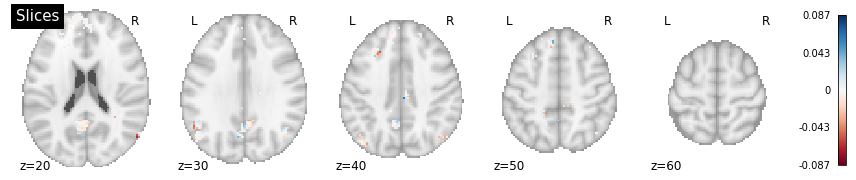

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


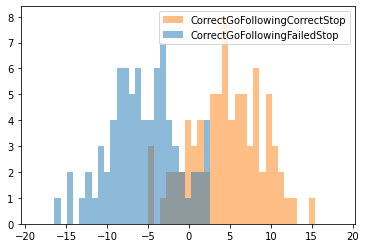

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


4.75617162160415 14.954550978713081 -10.198379357108932 19.710722600317233


-5.512766168889337 12.482105622666186 -17.994871791555525 6.969339453776849


-4.75617162160415 14.954550978713081 -19.710722600317233 10.198379357108932


5.512766168889337 12.482105622666186 -6.969339453776849 17.994871791555525


### PE_trials_PostError_similarity

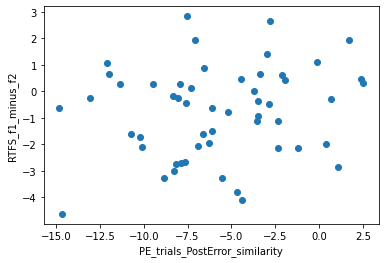

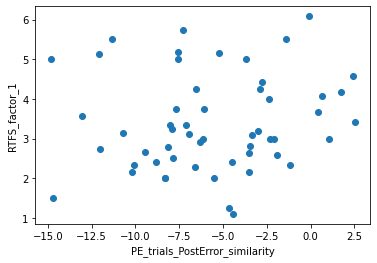

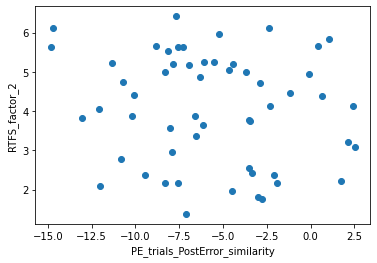

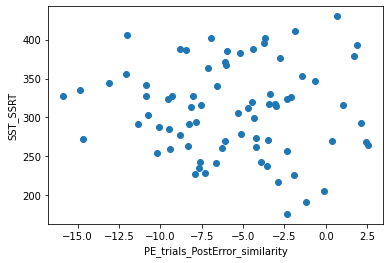

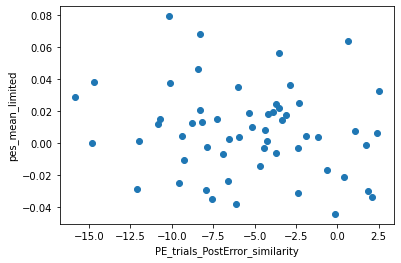

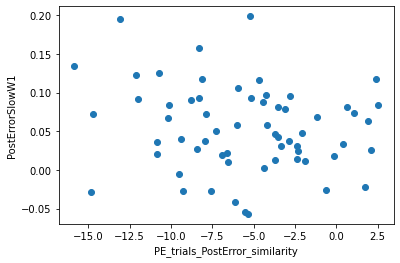

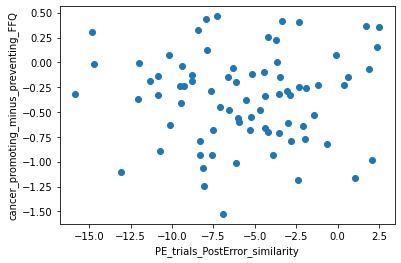

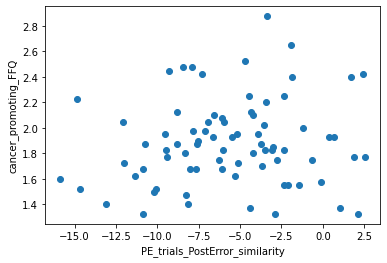

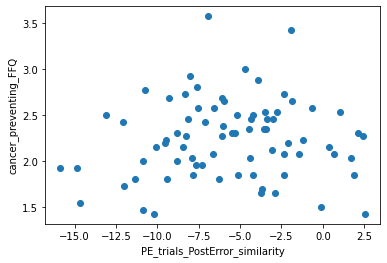

### PC_trials_PostCorrect_similarity

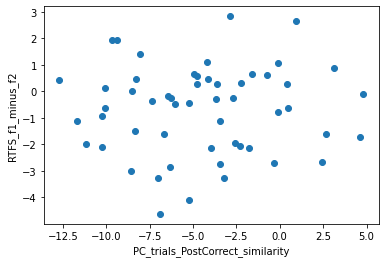

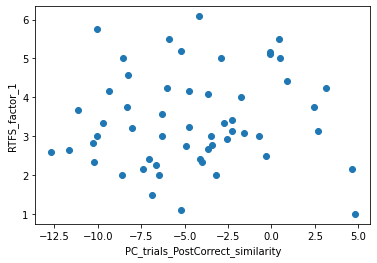

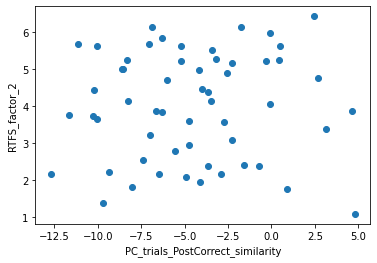

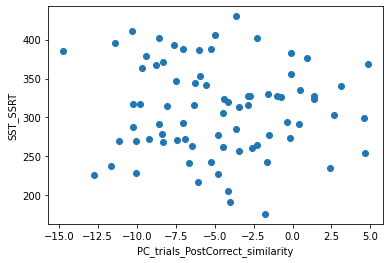

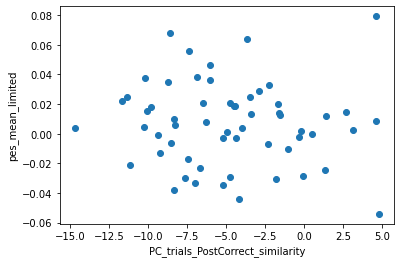

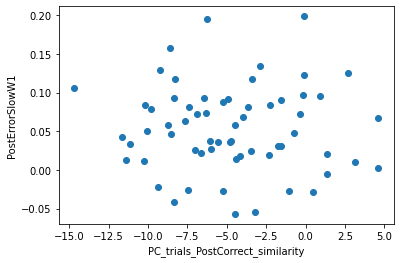

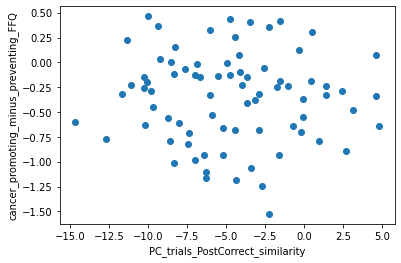

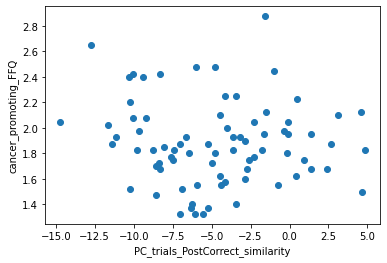

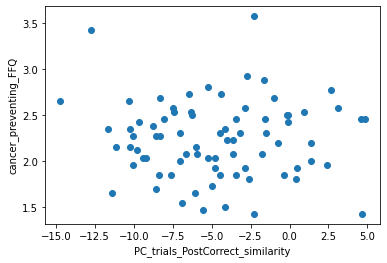

### Female

#### PE_trials_PostError_similarity

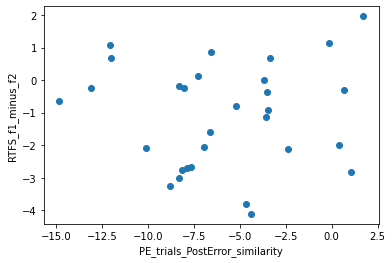

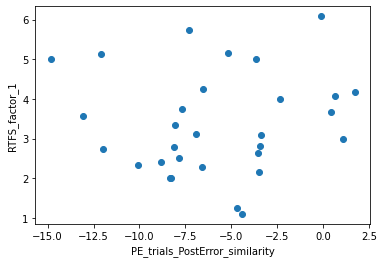

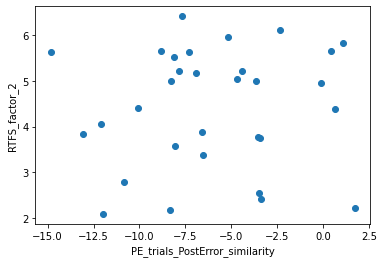

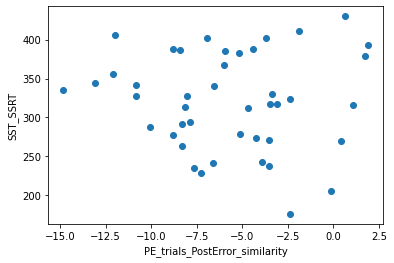

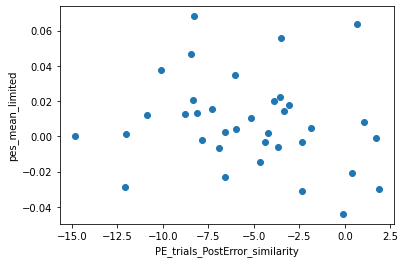

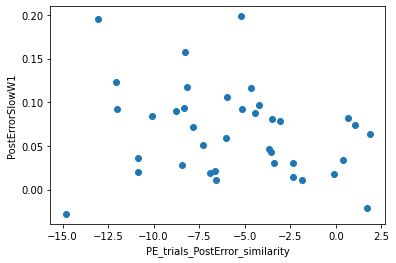

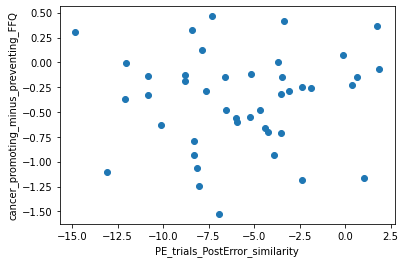

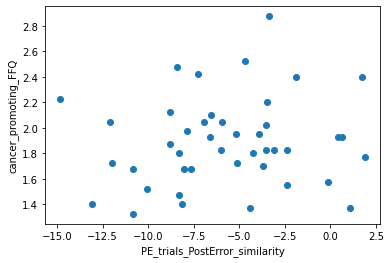

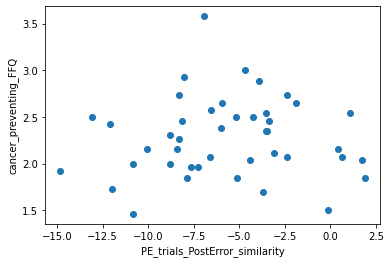

#### PC_trials_PostCorrect_similarity

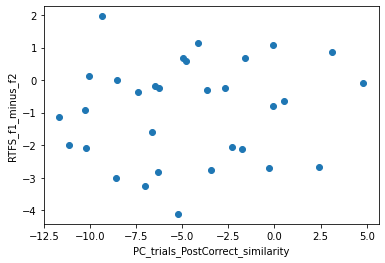

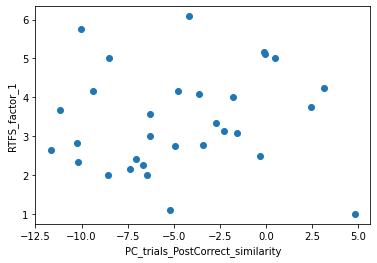

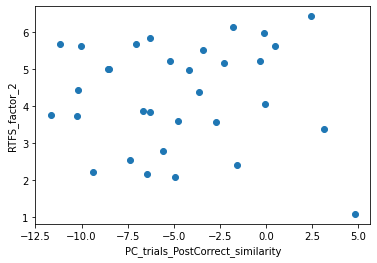

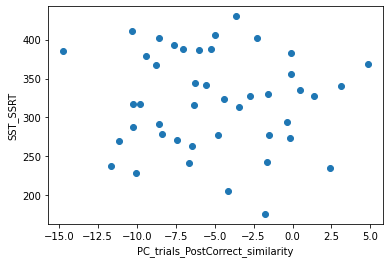

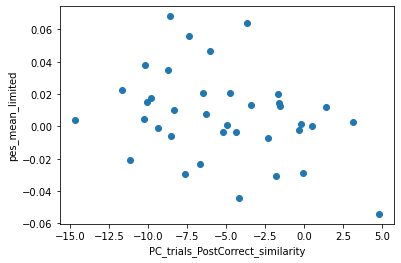

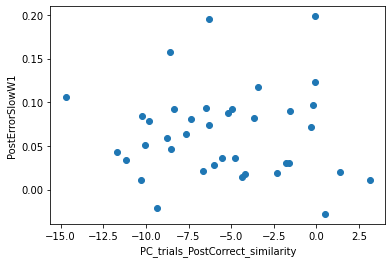

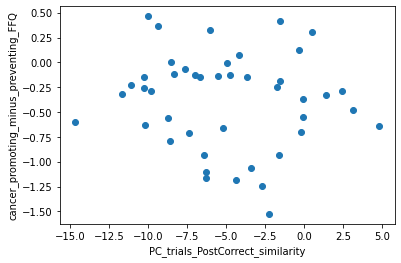

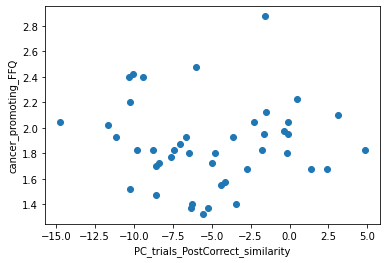

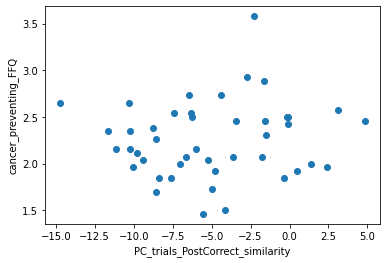

In [21]:
for k in mask_dict.keys():
    display(Markdown("# " + k))
    mask_bd = mask_dict[k]
    
    run_full_pes_analysis_no_male_specific(k,mask_bd,'dot_product')

In [22]:
ml_data_folderpath

'/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml'